# [PUBLIC LECTURE AT [DEEPHACK.RL](http://deeprl.tilda.ws)]

#  Cross-platform multi-objective optimisation via Collective Knowledge

In [1]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url="http://dividiti.com/dvdt/a_eq_dvdt_1000.png")

## Motivation: Autonomous Driving

### No, that's not quite what we mean!

In [2]:
Image(url="http://taxistartup.com/wp-content/uploads/2015/03/UK-Self-Driving-Cars.jpg")

### Convolutional Neutral Networks are the state-of-the-art

In [3]:
Image(url="http://image.slidesharecdn.com/pydatatalk-150729202131-lva1-app6892/95/deep-learning-with-python-pydata-seattle-2015-35-638.jpg?cb=1438315555")

### Today proof-of-concepts: ~10,000 W,  ~$10,000, and, look, no space for luggage!

In [4]:
Image(url="http://images.cdn.autocar.co.uk/sites/autocar.co.uk/files/styles/gallery_slide/public/audi-rs7-driverless-005.jpg?itok=A-GlUErw")

### Need 3-4 orders of magnitude improvement in terms of performance, power, cost, space!

In [5]:
Image(url="https://1.bp.blogspot.com/-aQw-r1FZcQk/VyINpA8ntxI/AAAAAAAAPF4/o34l1MvKJVQTuLD1qsv5Ink-04Dra0PDgCLcB/s1600/Movidius%2BFathom-1.JPG")

## Table of Contents

1. [Overview](#overview)
1. [See the code](#code) [for developers]
1. [Get the data](#data) [for developers]
1. [See the tables](#tables)
  1. [Accuracy](#df_accuracy)
  1. [All data](#df_all)
  1. [All execution time data](#df_time)
  1. [Mean execution time per batch](#df_mean_time_per_batch)
  1. [Mean execution time per image](#df_mean_time_per_image)
  1. [Best mean execution time per image](#df_best_mean_time_per_image)
1. [See the graphs - grouped by models](#plot_models)
  1. [Accuracy](#plot_accuracy)
  1. [All libs](#plot_models_all)
  1. [GPU libs](#plot_models_gpu)
  1. [CUDA-level performance libs](#plot_models_cuda)
  1. [cuBLAS libs](#plot_models_cublas)
  1. [cuDNN libs](#plot_models_cudnn)
1. [See the graphs - grouped by libs](#plot_libs)
  1. [All models](#plot_libs_all)
  1. [All models, GPU libs](#plot_libs_gpu)
  1. [Models with AlexNet-level accuracy](#plot_libs_alexnet)
  1. [Models with AlexNet-level accuracy, CPU lib](#plot_libs_alexnet_cpu) 
  1. [Models with AlexNet-level accuracy, CUDA-level perfomance libs](#plot_libs_alexnet_cuda)
  1. [Models with AlexNet-level accuracy, fp16 libs](#plot_libs_alexnet_fp16)
  1. [GoogleNet, fp16 libs](#plot_libs_googlenet_fp16)
1. [See the graphs - per layer execution time profiling](#plot_per_layer)
1. [See the graphs - the ideal adaptive solution](#plot_ideal)
  1. [Using all libs for adaptation](#plot_ideal_all)
  1. [Using CUDA-level performance libs for adaptation](#plot_ideal_cuda)
  1. [Using cuDNN and cuBLAS for adaptation](#plot_ideal_cudnn_cublas)
  1. [Using cuDNN and libDNN for adaptation](#plot_ideal_cudnn_libdnn)
1. [See the memory consumption graph](#plot_memory)
  1. [Balance memory consumption and execution time per image](#balance_memory_time)
1. [Compare AlexNet and SqueezeNet 1.1](#alexnet_vs_squeezenet)
  1. [Compare memory consumption](#alexnet_vs_squeezenet_memory)
  1. [Compare execution time](#alexnet_vs_squeezenet_time)
1. [Conclusion](#conclusion)
  1. [What are the improvements brought on by each approach?](#improvements_of_each_approach)
  1. [How does TX1 compare to Myriad2?](#tx1_vs_myriad2)
1. [Collective Knowledge on Deep Learning](#ck_on_dl)

<a id="overview"></a>
## Overview

This Jupyter Notebook compares the performance (execution time, memory consumption):
- on **[dividiti](http://dividiti.com)**'s Jetson TX1 board ([official page](http://www.nvidia.com/object/jetson-tx1-dev-kit.html), [Phoronix review](http://www.phoronix.com/scan.php?page=article&item=nvidia-jtx1-perf)):
  - CPU:
    - ARM&reg; Cortex&reg;-A57 architecture ("big");
    - 4 cores;
    - Max clock 1743 MHz;
  - GPU:
    - Maxwell&trade; architecture;
    - 256 CUDA cores;
    - Max clock 998 MHz;
  - RAM:
    - LPDDR4;
    - 4 GB (shared between the CPU and the GPU);
    - Max bandwidth 25.6 GB/s;
  - [Linux for Tegra 24.2.1](http://developer.download.nvidia.com/embedded/L4T/r24_Release_v2.1/Docs/Tegra_Linux_Driver_Package_Release_Notes_R24.2.1.pdf);
  - [JetPack 2.3.1](http://docs.nvidia.com/jetpack-l4t/index.html#developertools/desktop/jetpack/l4t/2.3.1);
  - CUDA Toolkit 8.0.33.
```
$ uname -a
Linux tegra-ubuntu 3.10.96-tegra #1 SMP PREEMPT Wed Nov 9 19:42:57 PST 2016 aarch64 aarch64 aarch64 GNU/Linux
$ cat /etc/lsb-release
DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=16.04
DISTRIB_CODENAME=xenial
DISTRIB_DESCRIPTION="Ubuntu 16.04.1 LTS"
```

- using 8 Caffe **libraries**:
  - [`tag`] **Branch** (**revision hash, date**): **math libraries**.
  - [`cpu`] Master ([24d2f67](https://github.com/BVLC/caffe/commit/24d2f67173db3344141dce24b1008efffbfe1c7d), 28/Nov/2016): with [OpenBLAS 0.2.19](https://github.com/xianyi/OpenBLAS/releases/tag/v0.2.19);
  - [`cuda`] Master ([24d2f67](https://github.com/BVLC/caffe/commit/24d2f67173db3344141dce24b1008efffbfe1c7d), 28/Nov/2016): with [cuBLAS](https://developer.nvidia.com/cublas) (part of CUDA Toolkit 8.0.33);
  - [`cudnn`] Master [24d2f67](https://github.com/BVLC/caffe/commit/24d2f67173db3344141dce24b1008efffbfe1c7d), 28/Nov/2016): with [cuDNN 5.1](https://developer.nvidia.com/cudnn);
  - [`libdnn-cuda`] OpenCL ([b735c2d](https://github.com/BVLC/caffe/commit/b735c2dd4103ac963332b400168507dd7cefd204), 23/Nov/2016): with [libDNN](https://github.com/BVLC/caffe/issues/4155) and [cuBLAS](https://developer.nvidia.com/cublas) (**NB:** not yet tuned for TX1; uses optimal parameters for GTX 1080);
  - [`nvidia-cuda`] NVIDIA v0.15 ([1024d34](https://github.com/NVIDIA/caffe/commit/1024d34d93cd34a9013d6fac4e56e45162073d38), 17/Nov/2016): with [cuBLAS](https://developer.nvidia.com/cublas) (part of CUDA Toolkit 8.0.33);
  - [`nvidia-cudnn`] NVIDIA v0.15 ([1024d34](https://github.com/NVIDIA/caffe/commit/1024d34d93cd34a9013d6fac4e56e45162073d38), 17/Nov/2016): with [cuDNN 5.1](https://developer.nvidia.com/cudnn);
  - [`nvidia-fp16-cuda`] NVIDIA experimental/fp16 ([fca1cf4](https://github.com/NVIDIA/caffe/commit/fca1cf475d1d0a6d355f8b9877abcc4e13951c9c), 11/Jul/2016): with [cuBLAS](https://developer.nvidia.com/cublas) (part of CUDA Toolkit 8.0.33);
  - [`nvidia-fp16-cudnn`] NVIDIA experimental/fp16 ([fca1cf4](https://github.com/NVIDIA/caffe/commit/fca1cf475d1d0a6d355f8b9877abcc4e13951c9c), 11/Jul/2016): with [cuDNN 5.1](https://developer.nvidia.com/cudnn);

- using 4 CNN **models**:
  - [GoogleNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet);
  - [AlexNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_alexnet);
  - [SqueezeNet 1.0](https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.0);
  - [SqueezeNet 1.1](https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1);

- with the **batch size** varying from 2 to 16 with step 2.

### Configure the execution time metric to use

In [6]:
fw = [ 'forward' ]
fwbw = [ 'forward', 'backward' ]

In [7]:
# Set to fw for inference; to fwbw for training.
direction = fw
direction

['forward']

In [8]:
if direction==fw:
    time_ms = 'time_fw_ms'
else: # direction==fwbw
    time_ms = 'time_fwbw_ms'
time_ms

'time_fw_ms'

In [9]:
def images_per_second(time_in_milliseconds):
    return 1000.0 / time_in_milliseconds

<a id="code"></a>
## Data wrangling code

**NB:** Please ignore this section if you are not interested in re-running or modifying this notebook.

### Includes

#### Standard

In [10]:
import os
import sys
import json
import re

#### Scientific

If some of the scientific packages are missing, please install them using:
```
# pip install jupyter pandas numpy matplotlib
```

In [11]:
import IPython as ip
import pandas as pd
import numpy as np
import matplotlib as mp

In [12]:
print ('IPython version: %s' % ip.__version__)
print ('Pandas version: %s' % pd.__version__)
print ('NumPy version: %s' % np.__version__)
print ('Matplotlib version: %s' % mp.__version__)

IPython version: 5.1.0
Pandas version: 0.19.0
NumPy version: 1.11.2
Matplotlib version: 1.5.3


In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

#### Collective Knowledge

If CK is not installed, please install it using:
```
# pip install ck
```

In [14]:
import ck.kernel as ck
print ('CK version: %s' % ck.__version__)

CK version: 1.8.6.1


### Pretty print libs and models

In [15]:
pretty_print_libs = {
    'cpu':              '[CPU] OpenBLAS',
    'libdnn-cuda':      '[GPU] libDNN-fp32',
    'nvidia-cuda':      '[GPU] cuBLAS-fp32',
    'nvidia-fp16-cuda': '[GPU] cuBLAS-fp16',
    'nvidia-cudnn':     '[GPU] cuDNN-fp32',
    'nvidia-fp16-cudnn':'[GPU] cuDNN-fp16'
}

pretty_print_models = {
    'bvlc-alexnet':'AlexNet',
    'bvlc-googlenet':'GoogleNet',
    'deepscale-squeezenet-1.0':'SqueezeNet 1.0',
    'deepscale-squeezenet-1.1':'SqueezeNet 1.1'
}

speedup_sort_models = [
    '[CPU] OpenBLAS',
    '[GPU] libDNN-fp32',
    '[GPU] cuBLAS-fp32',
    '[GPU] cuBLAS-fp16',
    '[GPU] cuDNN-fp32',
    '[GPU] cuDNN-fp16'
]

### Access the experimental data

In [16]:
def get_experimental_results(repo_uoa, tags):
    module_uoa = 'experiment'
    r = ck.access({'action':'search', 'repo_uoa':repo_uoa, 'module_uoa':module_uoa, 'tags':tags})
    if r['return']>0:
        print ("Error: %s" % r['error'])
        exit(1)
    experiments = r['lst']
    
    dfs = []
    for experiment in experiments:
        data_uoa = experiment['data_uoa']
        r = ck.access({'action':'list_points', 'repo_uoa':repo_uoa, 'module_uoa':module_uoa, 'data_uoa':data_uoa})
        if r['return']>0:
            print ("Error: %s" % r['error'])
            exit(1)

        # Get (lib_tag, model_tag) from a list of tags that should be available in r['dict']['tags'].
        # Tags include 2 of the 3 irrelevant tags, a model tag and a lib tag.
        # NB: Since it's easier to list all model tags than all lib tags, the latter list is not expicitly specified.
        tags = r['dict']['tags']
        irrelevant_tags = [ 'explore-batch-size-libs-models','time_gpu','time_cpu','time_gpu_fp16' ]
        model_tags = [ 'bvlc-alexnet','bvlc-googlenet','deepscale-squeezenet-1.0','deepscale-squeezenet-1.1' ]
        lib_model_tags = [ tag for tag in tags if tag not in irrelevant_tags ]
        model_tags = [ tag for tag in lib_model_tags if tag in model_tags ]
        lib_tags = [ tag for tag in lib_model_tags if tag not in model_tags ]
        if len(lib_tags)==1 and len(model_tags)==1:
            (lib, model) = (lib_tags[0], model_tags[0])
        else:
            continue
        
        for point in r['points']:
            with open(os.path.join(r['path'], 'ckp-%s.0001.json' % point)) as point_file:
                point_data_raw = json.load(point_file)
                # Obtain column data.
                characteristics = [
                    {
                        'time (ms)'   : characteristics['run'].get(time_ms,+1e9), # "positive infinity"
                        'memory (MB)' : characteristics['run'].get('memory_mbytes',-1),
                        'success?'    : characteristics['run'].get('run_success','n/a'),
                        'per layer info' : characteristics['run'].get('per_layer_info',[])
                    }
                    for characteristics in point_data_raw['characteristics_list'] 
                ]
                # Deal with missing column data (resulting from failed runs).
                if len(characteristics)==1:
                    repetitions = point_data_raw['features'].get('statistical_repetitions',1)
                    characteristics = characteristics * repetitions
                # Construct a DataFrame.
                df = pd.DataFrame(characteristics)
                # Set columns and index names.
                df.columns.name = 'run characteristic'
                df.index.name = 'repetition'
                # Set indices.
                if lib=='tensorrt-1.0.0':
                    enable_fp16 = (point_data_raw['choices']['env']['CK_TENSORRT_ENABLE_FP16'] != 0)
                    df['lib'] = 'tensorrt-fp%d' % (16 if enable_fp16 else 32)
                else:
                    df['lib'] = lib
                df['model'] = model
                df['batch size'] = point_data_raw['choices']['env']['CK_CAFFE_BATCH_SIZE']
                df = df.set_index(['lib', 'model', 'batch size'], append=True)
                df = df.reorder_levels(('model', 'lib', 'batch size', 'repetition'))
                # Append to the list of similarly constructed DataFrames.
                dfs.append(df)
    # Concatenate all constructed DataFrames (i.e. stack on top of each other).
    result = pd.concat(dfs)
    return result.sortlevel(result.index.names)

### Plot execution time per image or memory consumption

In [17]:
def plot(mean, std, title='Execution time per image (ms)', ymax=0, rot=0):
    ymax = mean.max().max() if ymax==0 else ymax
    mean.plot(yerr=std, ylim=[0,ymax*1.05], title=title,
        kind='bar', rot=rot, figsize=[16, 8], grid=True, legend=True, colormap=cm.autumn)

### Plot maximum number of images per second

In [18]:
# ['cuda', 'cudnn'] are roughly equivalent to ['nvidia-cuda', 'nvidia-cudnn'], so can be dropped.
def plot_max_num_images_per_second(df_mean_time_per_image, libs_to_drop=['cuda', 'cudnn'], rot=0):
    min_time_per_image = df_mean_time_per_image.min(axis=1).unstack('lib')
    max_num_images_per_second = images_per_second(min_time_per_image) \
        .drop(libs_to_drop, axis=1) \
        .rename(columns=pretty_print_libs, index=pretty_print_models) \
        .reindex(columns=speedup_sort_models)
    ax = max_num_images_per_second \
            .plot(title='Images/s (with the best even batch size between 2 and 16)', kind='bar',
                  figsize=[16, 8], width=0.95, rot=rot, grid=True, legend=True, colormap=cm.autumn)
    for patch in ax.patches:
         ax.annotate(str(int(patch.get_height()+0.5)), (patch.get_x()*1.00, patch.get_height()*1.01))

### Plot the speedup over a given baseline

In [19]:
# ['cuda', 'cudnn'] are roughly equivalent to ['nvidia-cuda', 'nvidia-cudnn'], so can be dropped.
def plot_speedup_over_baseline(df_mean_time_per_image, baseline='cpu', libs_to_drop=['cuda', 'cudnn'], rot=0):
    speedup_over_baseline = df_mean_time_per_image.min(axis=1).unstack('model').ix[baseline] / \
                            df_mean_time_per_image.min(axis=1).unstack('model')
    speedup_over_baseline = speedup_over_baseline.T \
        .drop(libs_to_drop, axis=1) \
        .rename(columns=pretty_print_libs, index=pretty_print_models) \
        .reindex(columns=speedup_sort_models)
    ax = speedup_over_baseline \
            .plot(title='Speedup over the given baseline (%s)' % pretty_print_libs[baseline], kind='bar',
                  figsize=[16, 8], width=0.95, rot=rot, grid=True, legend=True, colormap=cm.autumn)
    for patch in ax.patches:
        ax.annotate('{0:.2f}'.format(patch.get_height())[0:4], (patch.get_x()*1.00, patch.get_height()*1.01))

### Plot execution time per image per layer

In [20]:
# This transformation is time consuming, hence only call it once for multiple plots.
def get_per_layer_info(df_all):
    df_per_layer_info = df_all['per layer info']
    row_dfs = []
    for (row_info, row_id) in zip(df_per_layer_info, range(len(df_per_layer_info))):
        # Skip constructing a DataFrame when no layer info is available.
        if not row_info: continue
        # Augment each layer info with the row index: (model, lib, batch size, repetition).
        for layer_info in row_info:
            layer_info.update({ k : v for k, v in zip(df_per_layer_info.index.names, df_per_layer_info.index[row_id]) })
        # Construct a DataFrame and move the row index to where it belongs.
        row_df = pd.DataFrame(data=row_info).set_index(df_per_layer_info.index.names)
        row_dfs.append(row_df)
    return pd.concat(row_dfs)

In [21]:
def plot_time_per_image_per_layer(df_per_layer_info, model, libs, batch_sizes,
                                  direction=['forward'], lower=0.0, upper=1.0, ymax=0, rot=90):
    df_time_per_batch = df_per_layer_info.loc[model, libs, batch_sizes] \
        .set_index(['direction', 'label'], append=True) \
        .reorder_levels(['direction', 'label', 'model', 'lib', 'batch size', 'repetition' ]) \
        .ix[direction] \
        .reorder_levels(['label', 'model', 'lib', 'batch size', 'repetition', 'direction' ]) \
        .groupby(level=['label', 'model', 'lib', 'batch size', 'repetition']).sum() \
        ['time_ms']
    df_time_per_image = df_time_per_batch.unstack('batch size') / batch_sizes
    df = df_time_per_image.unstack(['lib', 'model'])
    df = df.reorder_levels(['model', 'lib', 'batch size'], axis=1)
    mean = df.groupby(level='label').mean()
    std = df.groupby(level='label').std()
    select = (lower*mean.sum() <= mean).any(axis=1) & (mean <= upper*mean.sum()).any(axis=1)
    ymax = mean[select].max().max() if ymax==0 else ymax
    plot(mean=mean[select], std=std[select], title='Execution time per image per layer (ms)', ymax=ymax, rot=rot)

### Plot the ideal adaptive solution

In [22]:
# The ideal adaptive solution for each layer selects the best performing library from the 'libs_for_adaptation' list.
# FIXME: add batch_sizes as explicit parameter.
def get_ideal_adaptive_solution(df_per_layer_info, libs_for_adaptation, direction):
    df_for_adaptation = df_per_layer_info \
        .set_index(['direction', 'label'], append=True) \
        .reorder_levels(['direction', 'lib', 'model', 'label', 'batch size', 'repetition']) \
        .ix[direction] \
        .reorder_levels(['lib', 'model', 'label', 'batch size', 'repetition', 'direction']) \
        .ix[libs_for_adaptation] \
        .reorder_levels(['model', 'label', 'lib', 'batch size', 'repetition', 'direction']) \
        ['time_ms']
    # With every step, reduce the rightmost dimension until the min time per model is reached.
    df_cum_time_per_repetition = df_for_adaptation.groupby(level=df_for_adaptation.index.names[:-1]).sum()
    df_min_time_per_repetition = df_cum_time_per_repetition.groupby(level=df_cum_time_per_repetition.index.names[:-1]).min()
    df_min_time_per_batch = df_min_time_per_repetition.unstack('batch size') / batch_sizes
    df_min_time_per_image = df_min_time_per_batch.min(axis=1)
    df_min_time_per_layer = df_min_time_per_image.groupby(level=df_min_time_per_image.index.names[:-1]).min()
    #df_min_time_per_model = df_min_time_per_layer.groupby(level=df_min_time_per_layer.index.names[:-1]).sum()
    # Transform to get the models in the index and the libs in the columns.
    df_min_time_per_layer_idx = df_min_time_per_image.groupby(level=df_min_time_per_image.index.names[:-1]).idxmin()
    df_ideal = df_min_time_per_image[df_min_time_per_layer_idx] \
        .reorder_levels(['model', 'lib', 'label']) \
        .groupby(level=['model', 'lib']).sum() \
        .unstack('lib')
    # Sort in the order of increasing time per model.
    df_ideal_sorted = df_ideal.ix[df_ideal.sum(axis=1).sort_values(ascending=True).index]
    return df_ideal_sorted

In [23]:
def plot_ideal_adaptive_solution(df_ideal, df_real, tag=""):
    figsize=[15, 3]
    if not tag=="": figsize=[10, 2] # good for dumping png (e.g. 3 graphs fit well onto a slide).
    for model in df_ideal.index:
        df_data = {}; df_data['adaptive'] = df_ideal.ix[model]
        for lib in df_ideal.columns:
            df_data[lib] = pd.Series(index=df_ideal.columns)
            df_data[lib][lib] = df_real.ix[model, lib]
        df = pd.DataFrame(df_data).T \
            .rename(index={'cpu': 'OpenBLAS only', 'nvidia-cuda':'cuBLAS only', 'nvidia-cudnn':'cuDNN only', 'libdnn-cuda': 'libDNN only'},
                    columns={'cpu': 'OpenBLAS', 'nvidia-cuda':'cuBLAS', 'nvidia-cudnn':'cuDNN', 'libdnn-cuda': 'libDNN'})
        ax = df.ix[df.sum(axis=1).sort_values(ascending=True).index] \
            .plot(title='%s - execution time per image (ms)' % model, kind='barh', stacked=True,
                  grid=True, legend=True, colormap=cm.summer_r, figsize=figsize, width=0.9) \
            .legend(loc='lower right')
        if not tag=="": ax.get_figure().savefig('%s.%s.png' % (tag, model))

### Plot execution time per image and memory consumption

In [24]:
def plot_time_per_image_and_memory_consumption(df_all, model, lib):
    df = df_all[['time (ms)', 'memory (MB)']] \
        .groupby(level=df_all.index.names[:-1]).mean() \
        .loc[model, lib]
    df['time per image (ms)'] = df['time (ms)'].divide(df.index, axis=0)
    df['memory per image (MB)'] = df['memory (MB)'].divide(df.index, axis=0)
    df = df.drop('time (ms)', axis=1).sortlevel(axis=1)
    ax = df.plot(secondary_y=['memory (MB)', 'memory per image (MB)'], title='%s w/ %s' % (model, lib),
                 figsize=[12, 8], mark_right=False, colormap=cm.winter, grid=True)
    ax.set_ylabel('execution time (ms)'); ax.legend(loc='center left'); ax.set_ylim(0)
    ax.right_ax.set_ylabel('memory consumption (MB)'); ax.right_ax.legend(loc='center right')

<a id="data"></a>
## Get the experimental data

**NB:** Please ignore this section if you are not interested in re-running or modifying this notebook.

The experimental data was collected on the experimental platform (after installing all Caffe libraries and models of interest)  as follows:
```
$ cd `ck find ck-caffe:script:explore-batch-size-libs-models`
$ python explore-batch-size-libs-models-benchmark.py
```
It can be downloaded from GitHub via CK as follows:
```
$ ck pull repo:ck-caffe-nvidia-tx1 --url=https://github.com/dividiti/ck-caffe-nvidia-tx1
```

<a id="tables"></a>
## Tables

<a id="df_accuracy"></a>
### Accuracy on the ImageNet validation set

In [25]:
alexnet_accuracy = (0.568279, 0.799501)
squeezenet_1_0_accuracy = (0.576801, 0.803903)
squeezenet_1_1_accuracy = (0.58388, 0.810123)
googlenet_accuracy = (0.689299, 0.891441)

df_accuracy = pd.DataFrame(
    columns=[['Accuracy, %']*2, ['Top 1', 'Top 5']],
    data=[alexnet_accuracy, squeezenet_1_0_accuracy, squeezenet_1_1_accuracy, googlenet_accuracy], 
    index=['AlexNet', 'SqueezeNet 1.0', 'SqueezeNet 1.1', 'GoogleNet']
)
df_accuracy

Accuracy, %          
                     Top 1     Top 5
AlexNet           0.568279  0.799501
SqueezeNet 1.0    0.576801  0.803903
SqueezeNet 1.1    0.583880  0.810123
GoogleNet         0.689299  0.891441

<a id="df_all"></a>
### All performance data

In [26]:
df_all = get_experimental_results(repo_uoa='ck-caffe-nvidia-tx1', tags='explore-batch-size-libs-models')

<a id="df_time"></a>
### All execution time data indexed by repetitions

In [27]:
df_time = df_all['time (ms)'].unstack(df_all.index.names[:-1])

<a id="df_mean_time_per_batch"></a>
### Mean execution time per batch

In [28]:
df_mean_time_per_batch = df_time.describe().ix['mean'].unstack(level='batch size')

In [29]:
batch_sizes = df_mean_time_per_batch.columns.tolist()
# batch_sizes

<a id="df_mean_time_per_image"></a>
### Mean execution time per image

In [30]:
df_mean_time_per_image = df_mean_time_per_batch / batch_sizes

<a id="df_best_mean_time_per_image"></a>
### Best mean execution time per image

In [31]:
df_mean_time_per_image.min(axis=1)

model                     lib              
bvlc-alexnet              cpu                  124.327292
                          libdnn-cuda           14.621250
                          nvidia-cuda           10.079646
                          nvidia-cudnn           7.413354
                          nvidia-fp16-cuda       8.583306
                          nvidia-fp16-cudnn      5.064858
bvlc-googlenet            cpu                  358.322708
                          libdnn-cuda           32.677375
                          nvidia-cuda           24.059604
                          nvidia-cudnn          17.109729
                          nvidia-fp16-cuda      21.820375
                          nvidia-fp16-cudnn     11.130854
deepscale-squeezenet-1.0  cpu                  125.432222
                          libdnn-cuda           19.493929
                          nvidia-cuda           16.057958
                          nvidia-cudnn          13.002875
                          nv

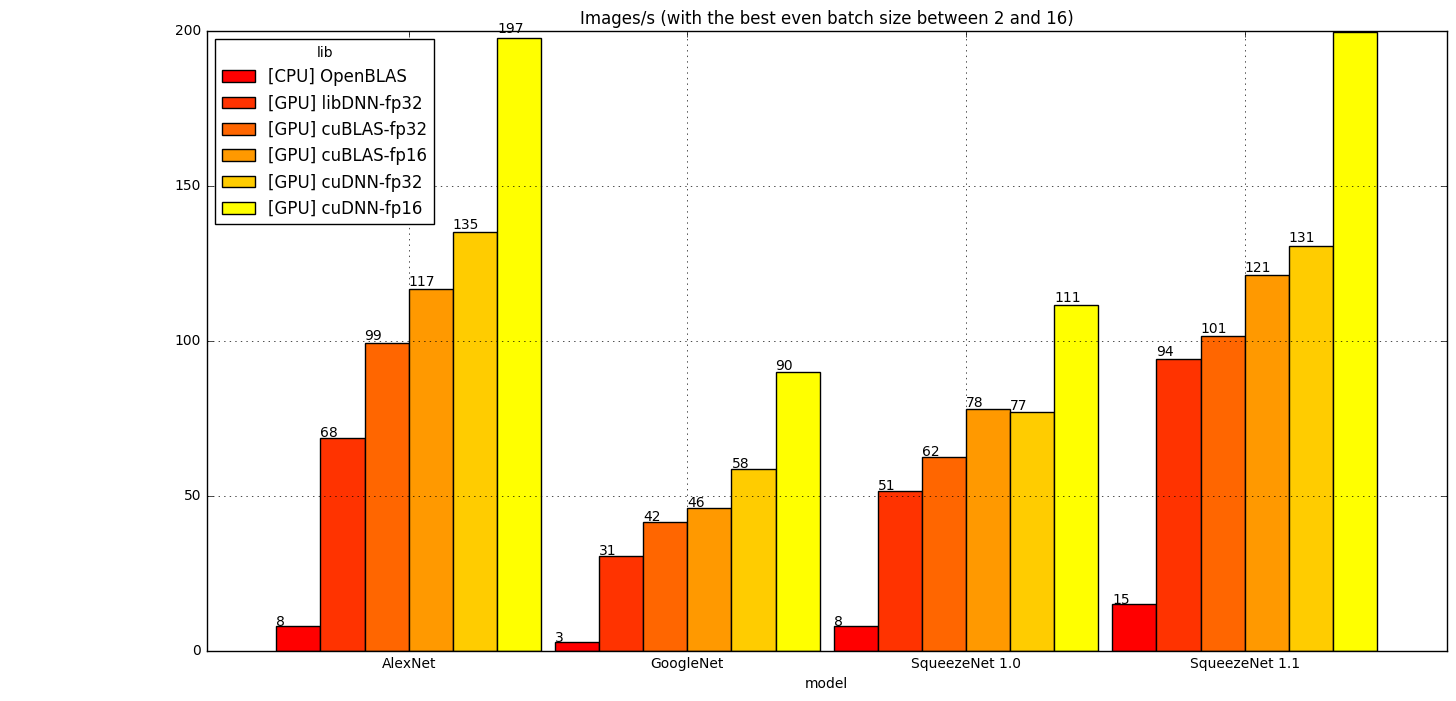

In [32]:
plot_max_num_images_per_second(df_mean_time_per_image, libs_to_drop=[])

In [33]:
# What is the batch size that gives the minimum time per image (or the maximum number of images per second)?
df_mean_time_per_image.idxmin(axis=1)

model                     lib              
bvlc-alexnet              cpu                  16
                          libdnn-cuda          16
                          nvidia-cuda          16
                          nvidia-cudnn         16
                          nvidia-fp16-cuda     12
                          nvidia-fp16-cudnn    16
bvlc-googlenet            cpu                  16
                          libdnn-cuda          16
                          nvidia-cuda          16
                          nvidia-cudnn         16
                          nvidia-fp16-cuda     16
                          nvidia-fp16-cudnn    16
deepscale-squeezenet-1.0  cpu                  12
                          libdnn-cuda          14
                          nvidia-cuda          16
                          nvidia-cudnn         16
                          nvidia-fp16-cuda     16
                          nvidia-fp16-cudnn    16
deepscale-squeezenet-1.1  cpu                  14
      

In [34]:
# Focus on e.g. nvidia-fp16-cuda, for which the batch size of 16 is not always the best.
df_mean_time_per_image.idxmin(axis=1).reorder_levels(['lib', 'model']).loc['nvidia-fp16-cuda']

model
bvlc-alexnet                12
bvlc-googlenet              16
deepscale-squeezenet-1.0    16
deepscale-squeezenet-1.1    14
dtype: int64

In [35]:
df_time_per_image = df_time / (batch_sizes*(len(df_time.columns)/len(batch_sizes)))

In [36]:
df_min_time_per_image_index = pd.DataFrame(df_mean_time_per_image.idxmin(axis=1)).set_index(0, append=True).index.values

In [37]:
df_model_lib = df_time_per_image[df_min_time_per_image_index] \
    .stack(['model', 'lib']).reorder_levels(['model','lib','repetition']).sum(axis=1)

In [38]:
df_model_lib_mean = df_model_lib.groupby(level=['model', 'lib']).mean()
df_model_lib_std  = df_model_lib.groupby(level=['model', 'lib']).std()

In [39]:
zero_positive_infinity = df_model_lib_mean > 1e5
df_model_lib_mean[zero_positive_infinity] = 0

<a id="plot_models"></a>
## Plot by Caffe models

<a id="plot_accuracy"></a>
### Accuracy  on the ImageNet validation set

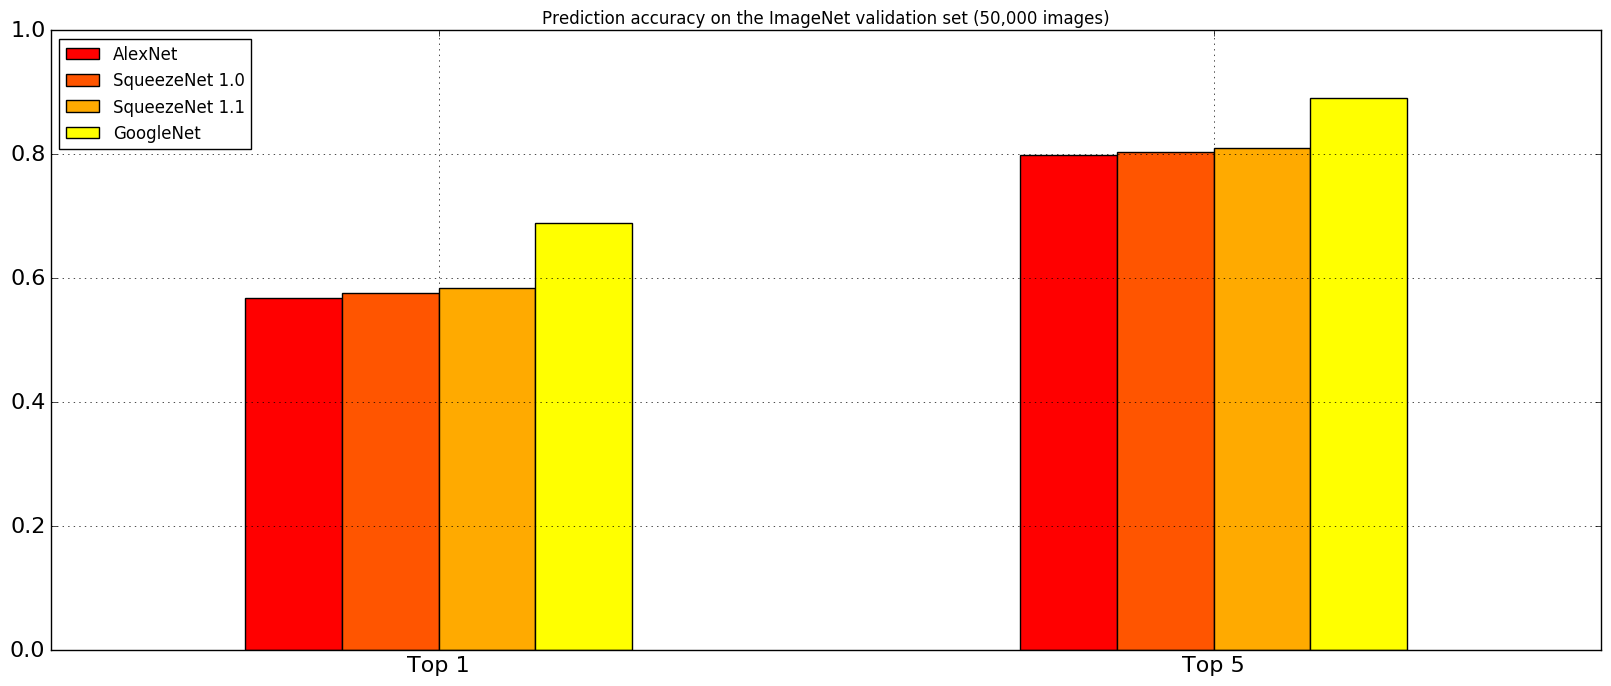

In [40]:
df_accuracy['Accuracy, %'].T \
    .plot(title='Prediction accuracy on the ImageNet validation set (50,000 images)',
          kind='bar', rot=0, ylim=[0,1], figsize=[20, 8], grid=True, legend=True, colormap=cm.autumn, fontsize=16)

<a id="plot_models_all"></a>
### All libs

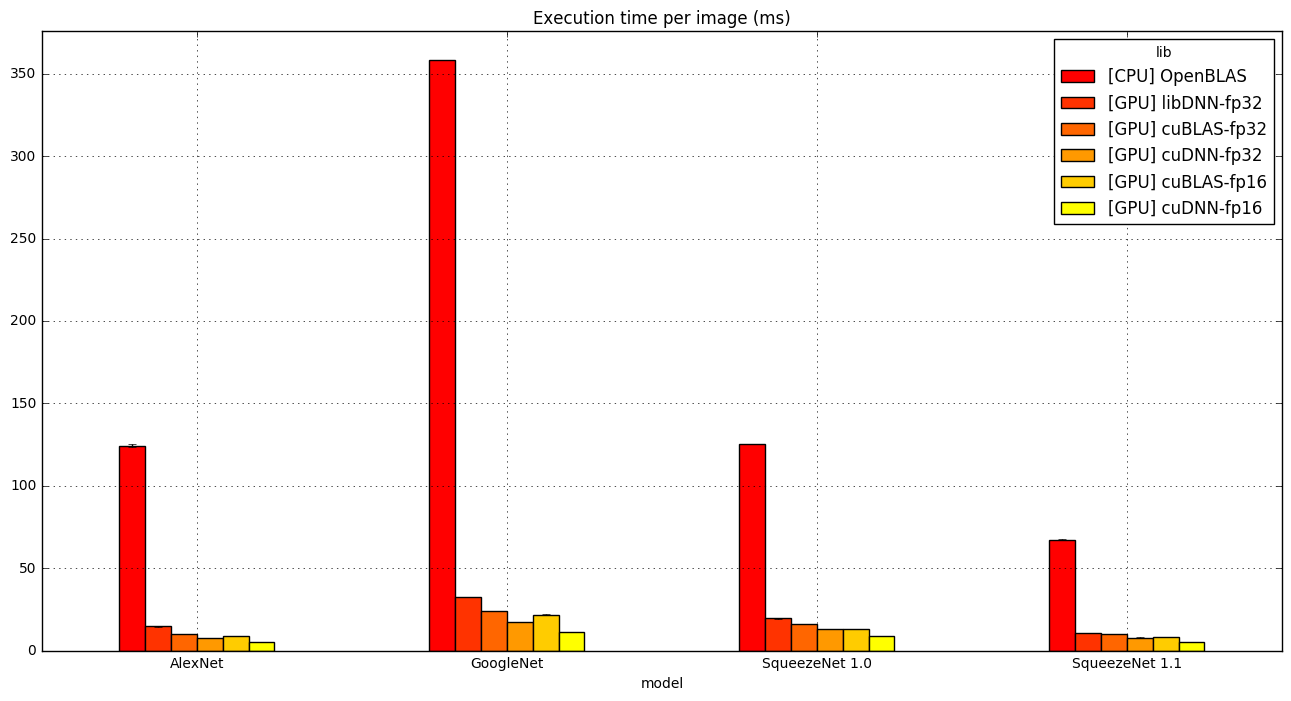

In [41]:
mean = df_model_lib_mean.unstack('lib').rename(columns=pretty_print_libs, index=pretty_print_models)
std  = df_model_lib_std.unstack('lib').rename(columns=pretty_print_libs, index=pretty_print_models)
plot(mean, std)

<a id="plot_models_gpu"></a>
### Only GPU libs

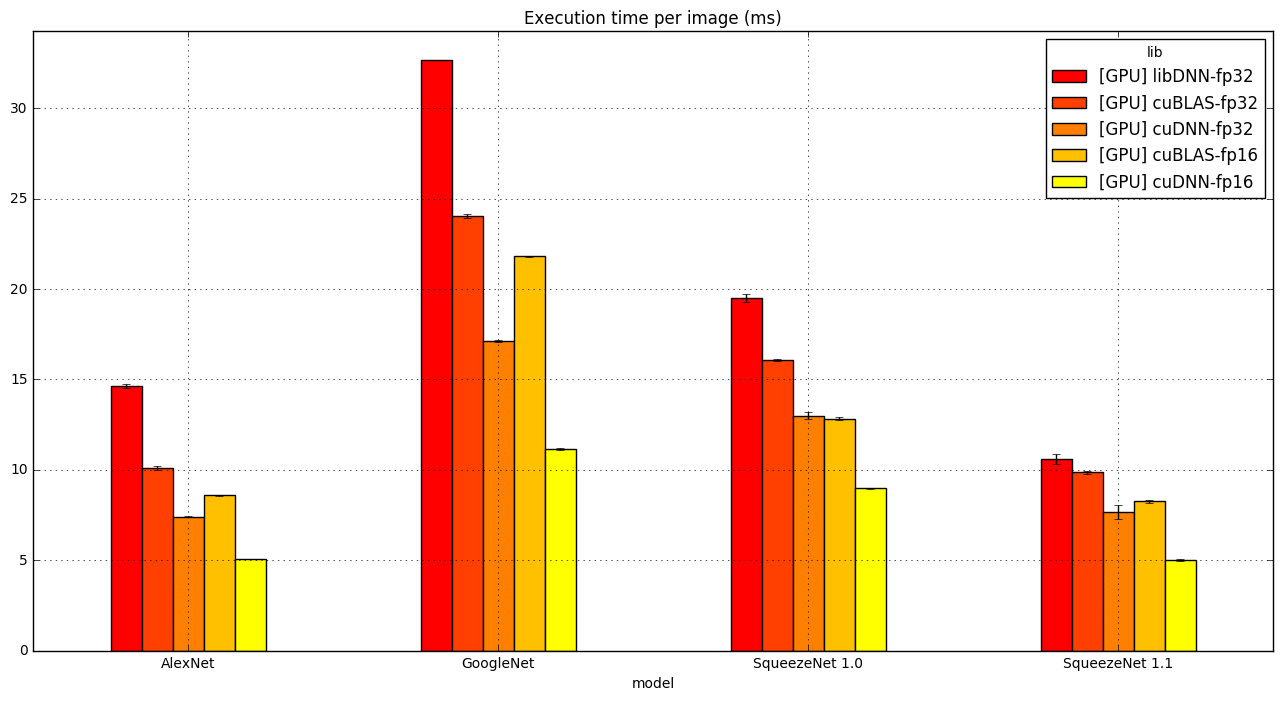

In [42]:
mean = df_model_lib_mean.unstack('lib').drop('cpu', axis=1) \
            .rename(columns=pretty_print_libs, index=pretty_print_models)
std  = df_model_lib_std.unstack('lib').drop('cpu', axis=1) \
            .rename(columns=pretty_print_libs, index=pretty_print_models)
plot(mean, std)

<a id="plot_models_cuda"></a>
### CUDA-level performance

In [43]:
cuda_level_performance = ['nvidia-cuda', 'nvidia-cudnn', 'libdnn-cuda']

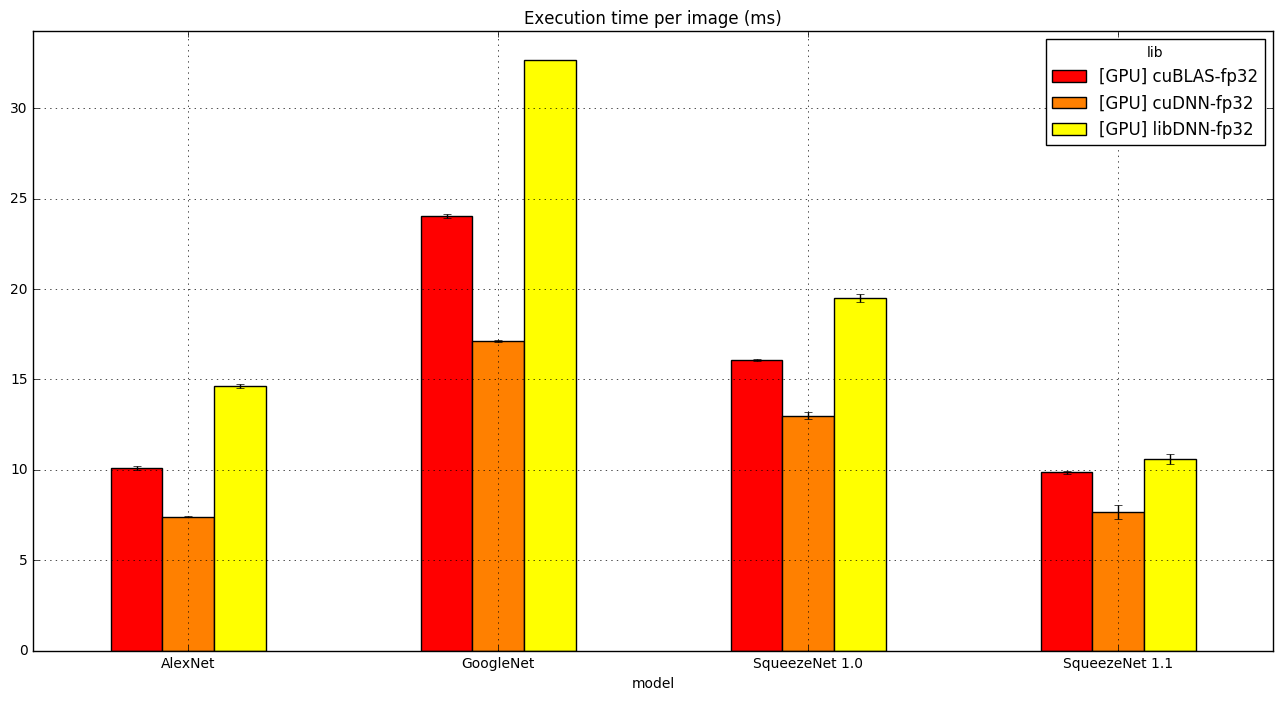

In [44]:
mean = df_model_lib_mean.reorder_levels(['lib', 'model'])[cuda_level_performance] \
            .unstack('lib').rename(columns=pretty_print_libs, index=pretty_print_models)
std = df_model_lib_std.reorder_levels(['lib', 'model'])[cuda_level_performance] \
            .unstack('lib').rename(columns=pretty_print_libs, index=pretty_print_models)
plot(mean, std)

<a id="plot_models_cublas"></a>
### cuBLAS

In [45]:
cublas_libs = ['nvidia-cuda', 'nvidia-fp16-cuda']

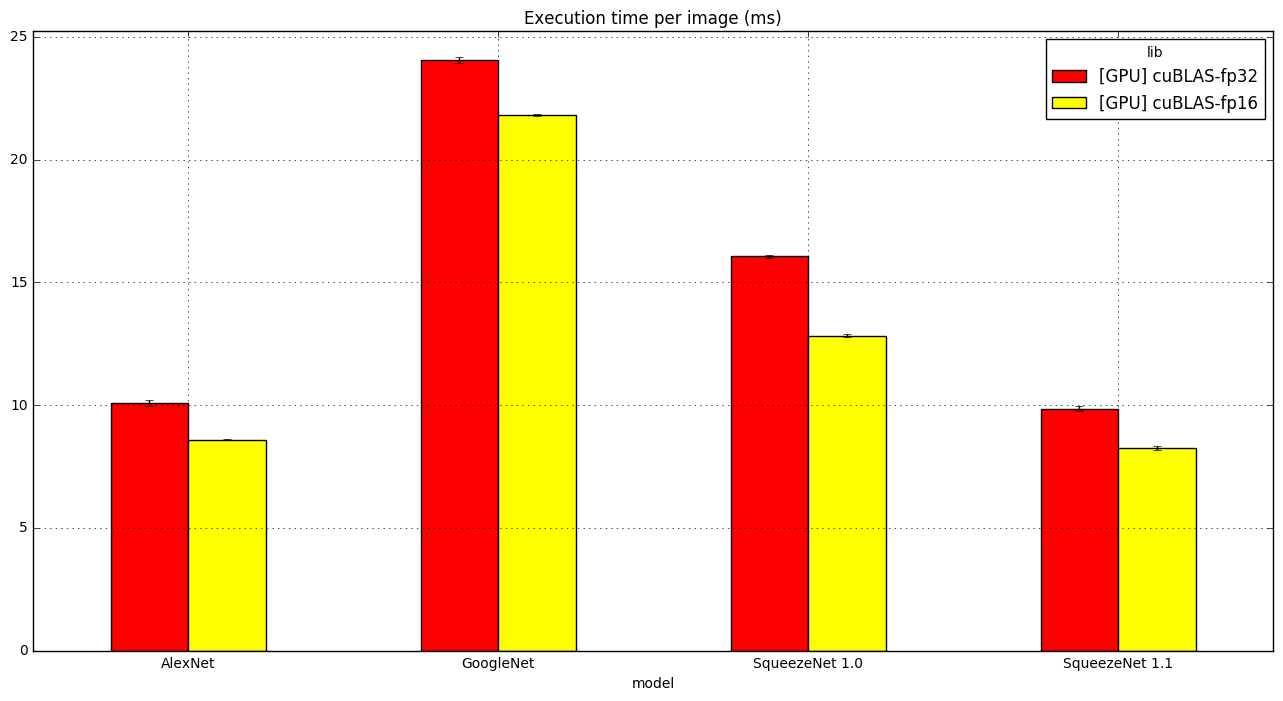

In [46]:
mean = df_model_lib_mean.reorder_levels(['lib', 'model'])[cublas_libs] \
        .unstack('lib').rename(columns=pretty_print_libs, index=pretty_print_models)
std = df_model_lib_std.reorder_levels(['lib', 'model'])[cublas_libs] \
        .unstack('lib').rename(columns=pretty_print_libs, index=pretty_print_models)
plot(mean, std)

In [47]:
# With cuBLAS, NVIDIA's fp16 branch is up to 20% faster than NVIDIA's fp32 mainline.
nvidia_fp16_cuda_vs_nvidia_fp32_cuda = mean['[GPU] cuBLAS-fp16'] / mean['[GPU] cuBLAS-fp32']
nvidia_fp16_cuda_vs_nvidia_fp32_cuda

model
AlexNet           0.851548
GoogleNet         0.906930
SqueezeNet 1.0    0.799011
SqueezeNet 1.1    0.837633
dtype: float64

<a id="plot_models_cudnn"></a>
### cuDNN

In [48]:
cudnn_libs = ['nvidia-cudnn', 'nvidia-fp16-cudnn']

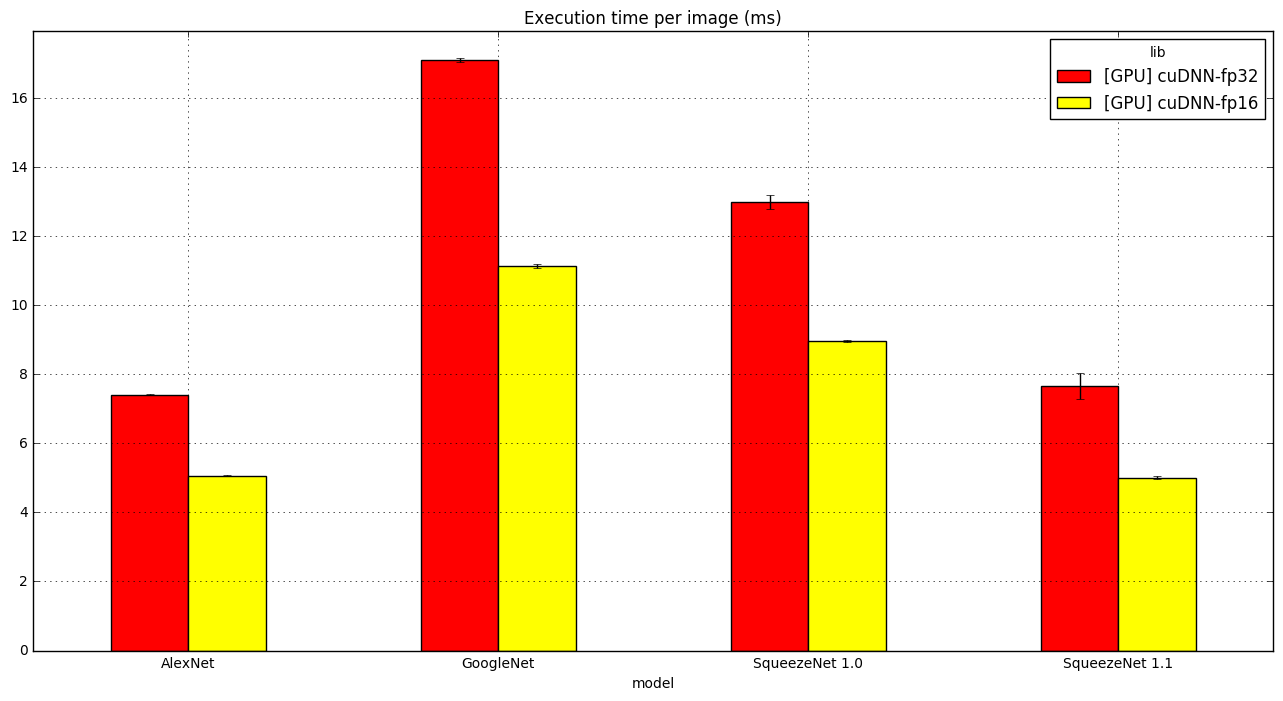

In [49]:
mean = df_model_lib_mean.reorder_levels(['lib', 'model'])[cudnn_libs] \
            .unstack('lib').rename(columns=pretty_print_libs, index=pretty_print_models)
std = df_model_lib_std.reorder_levels(['lib', 'model'])[cudnn_libs] \
            .unstack('lib').rename(columns=pretty_print_libs, index=pretty_print_models)
plot(mean, std)

In [50]:
# With cuDNN, NVIDIA's fp16 branch is up to 35% (roughly one third) faster than NVIDIA's fp32 mainline.
nvidia_fp16_cudnn_vs_nvidia_fp32_cudnn = mean['[GPU] cuDNN-fp16'] / mean['[GPU] cuDNN-fp32']
nvidia_fp16_cudnn_vs_nvidia_fp32_cudnn

model
AlexNet           0.683207
GoogleNet         0.650557
SqueezeNet 1.0    0.689820
SqueezeNet 1.1    0.654235
dtype: float64

<a id="plot_libs"></a>
## Plot by Caffe libs

<a id="plot_libs_all"></a>
### All

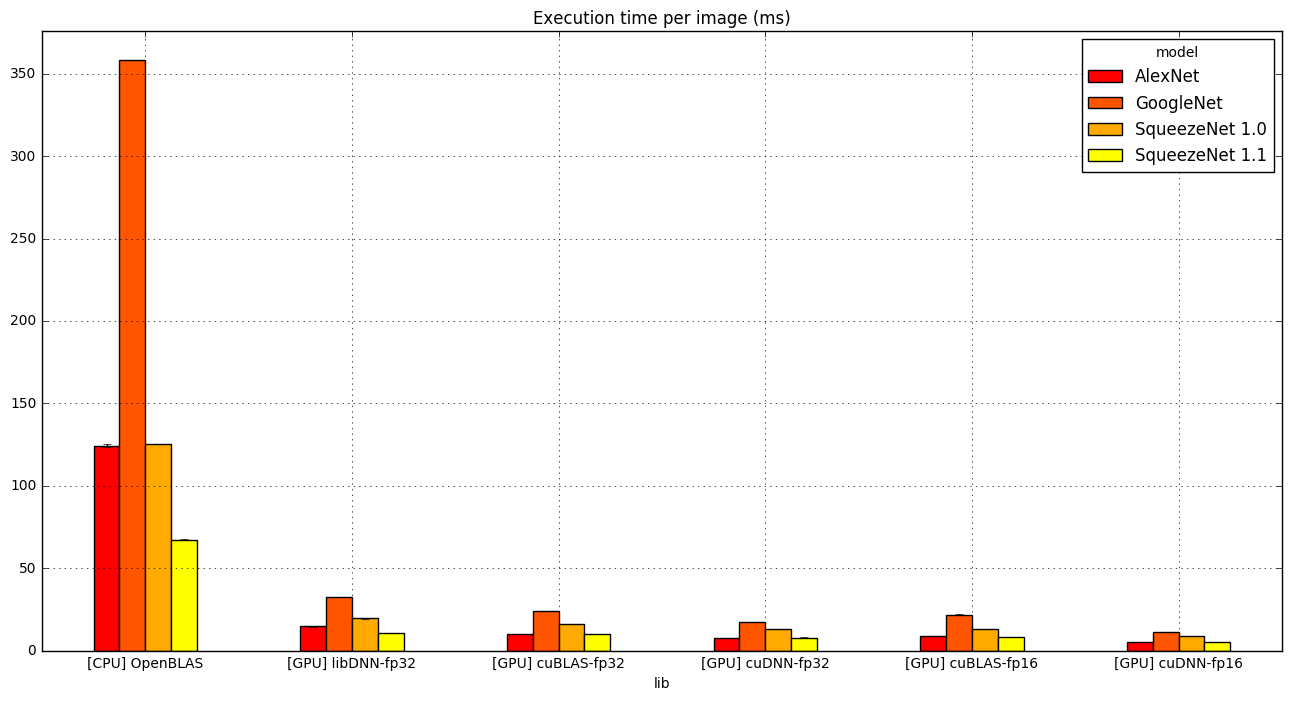

In [51]:
mean = df_model_lib_mean.unstack('model').rename(index=pretty_print_libs, columns=pretty_print_models)
std  = df_model_lib_std.unstack('model').rename(index=pretty_print_libs, columns=pretty_print_models)
plot(mean, std)

<a id="plot_libs_gpu"></a>
### All models, only GPU libs

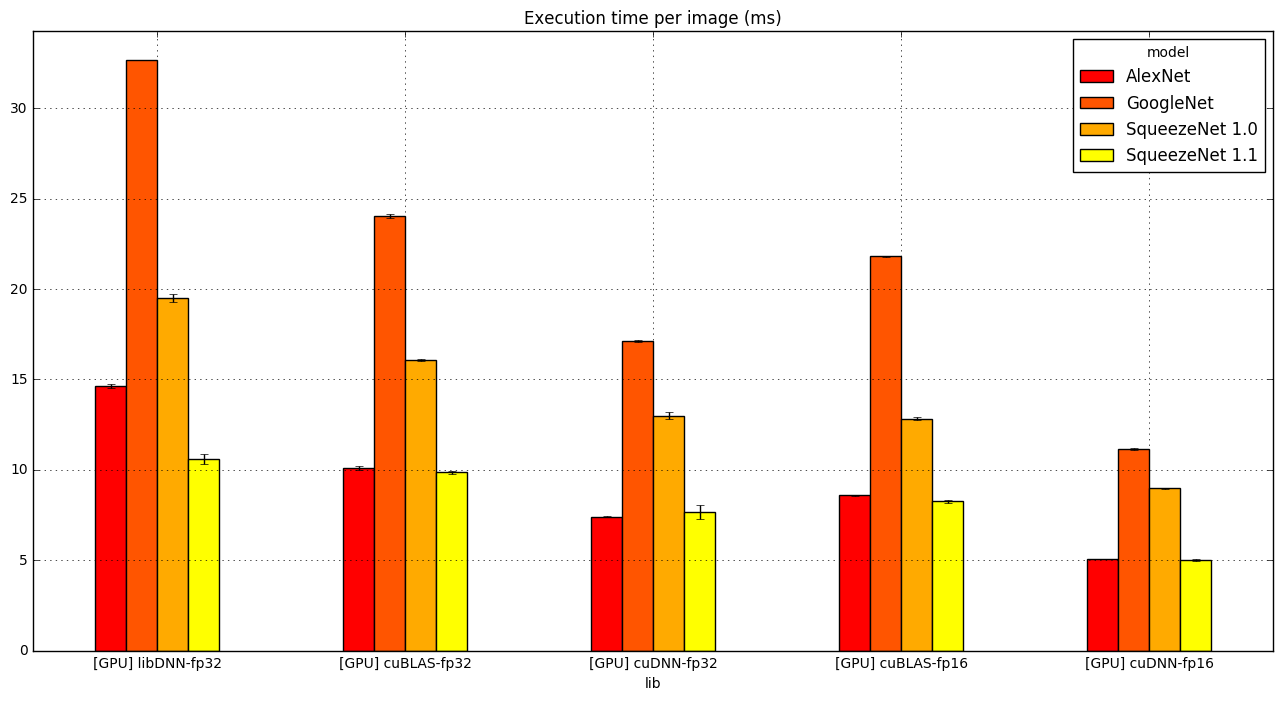

In [52]:
mean = df_model_lib_mean.unstack('model').drop('cpu', axis=0) \
            .rename(index=pretty_print_libs, columns=pretty_print_models)
std  = df_model_lib_std.unstack('model').drop('cpu', axis=0) \
            .rename(index=pretty_print_libs, columns=pretty_print_models)
plot(mean, std)

<a id="plot_libs_alexnet"></a>
### Only models with AlexNet-level accuracy

In [53]:
alexnet_level_accuracy = ['bvlc-alexnet','deepscale-squeezenet-1.0','deepscale-squeezenet-1.1']

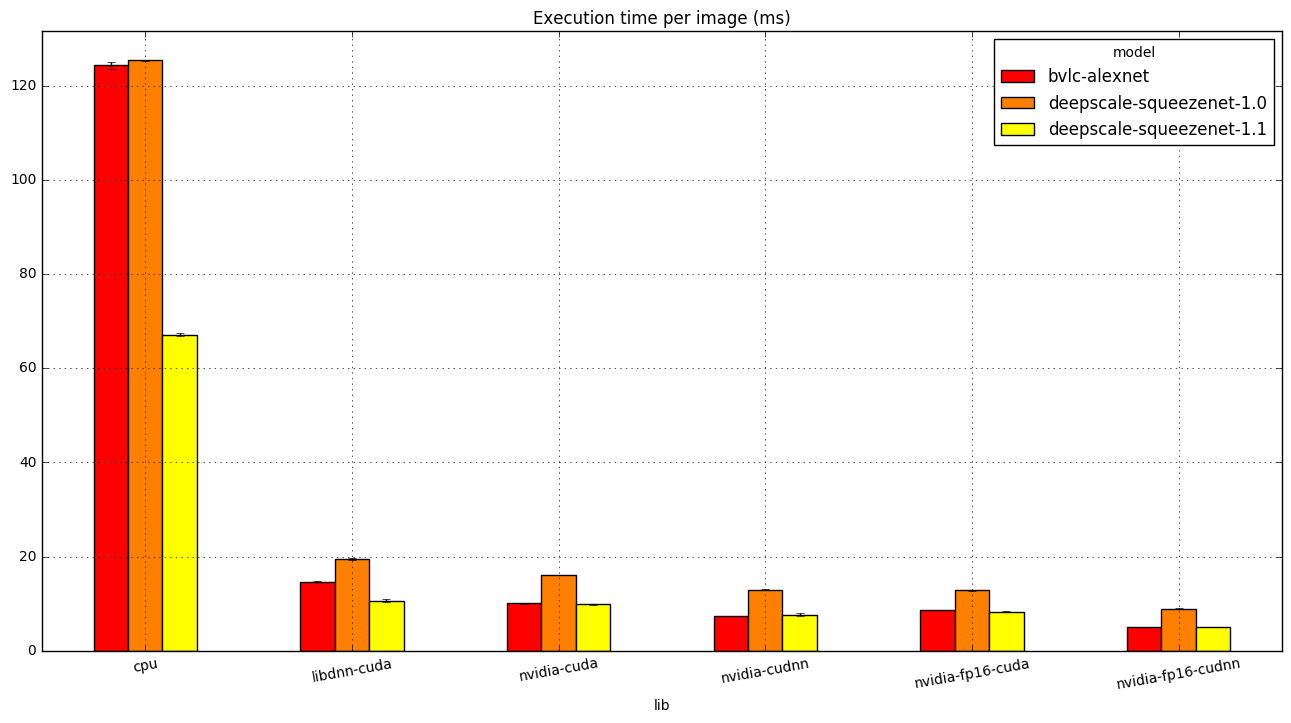

In [54]:
# On this platform with all the libraries, SqueezeNet 1.0 is always slower than AlexNet
# despite a 50x reduction in weights (5 MB vs. 250 MB).
mean = df_model_lib_mean[alexnet_level_accuracy].unstack('model')
std  = df_model_lib_std[alexnet_level_accuracy].unstack('model')
plot(mean, std, rot=10)

<a id="plot_libs_alexnet_cpu"></a>
### Only models with AlexNet-level accuracy, only CPU lib

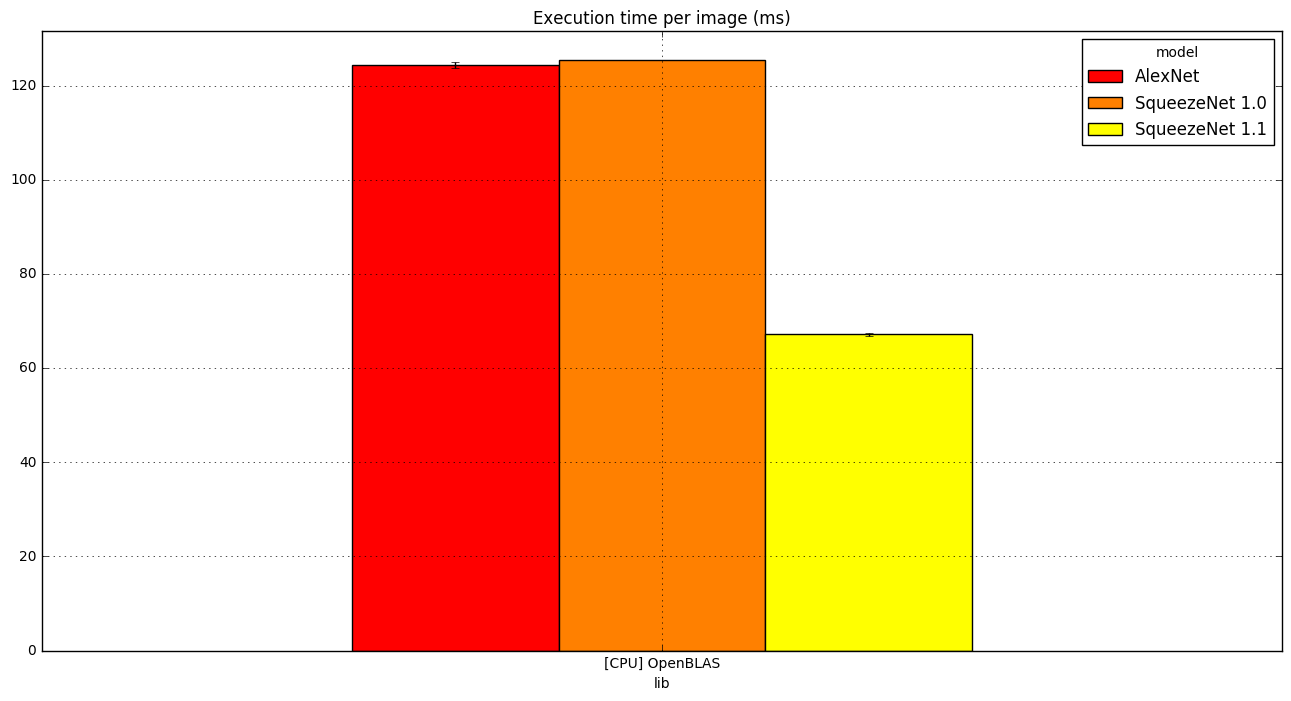

In [55]:
# SqueezeNet 1.1 is 46% faster than AlexNet with OpenBLAS (on the CPU).
mean = df_model_lib_mean[alexnet_level_accuracy].unstack('model').ix[['cpu']] \
            .rename(index=pretty_print_libs, columns=pretty_print_models)
std  = df_model_lib_std[alexnet_level_accuracy].unstack('model').ix[['cpu']] \
            .rename(index=pretty_print_libs, columns=pretty_print_models)
plot(mean, std)

In [56]:
mean['SqueezeNet 1.1'] / mean['AlexNet']

lib
[CPU] OpenBLAS    0.540034
dtype: float64

<a id="plot_libs_alexnet_cuda"></a>
### Only models with AlexNet-level accuracy, only libs with CUDA-level performance

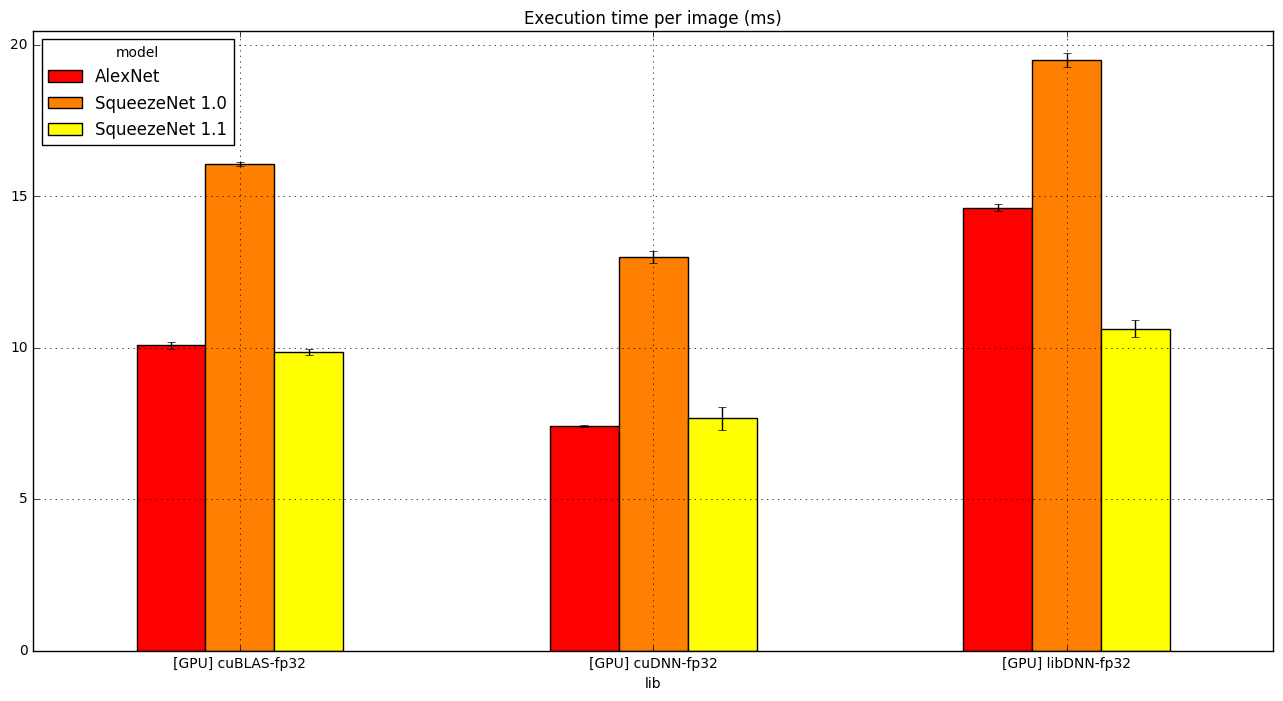

In [57]:
# SqueezeNet 1.0 is slower than AlexNet. SqueezeNet 1.1 is 28% faster than AlexNet with 
# libDNN-CUDA, and roughly equivalent to AlexNet with cuBLAS and cuDNN.
mean = df_model_lib_mean[alexnet_level_accuracy].unstack('model').ix[cuda_level_performance] \
            .rename(index=pretty_print_libs, columns=pretty_print_models)
std  = df_model_lib_std[alexnet_level_accuracy].unstack('model').ix[cuda_level_performance] \
            .rename(index=pretty_print_libs, columns=pretty_print_models)
plot(mean, std)

In [58]:
mean['SqueezeNet 1.1'] / mean['AlexNet']

lib
[GPU] cuBLAS-fp32    0.977500
[GPU] cuDNN-fp32     1.033459
[GPU] libDNN-fp32    0.726139
dtype: float64

<a id="plot_per_layer"></a>
## Plot execution time per image per layer

In [59]:
df_per_layer_info = get_per_layer_info(df_all)

In [60]:
# pd.options.display.max_columns = len(df_per_layer_info.columns)
# pd.options.display.max_rows = len(df_per_layer_info.index)
# df_per_layer_info

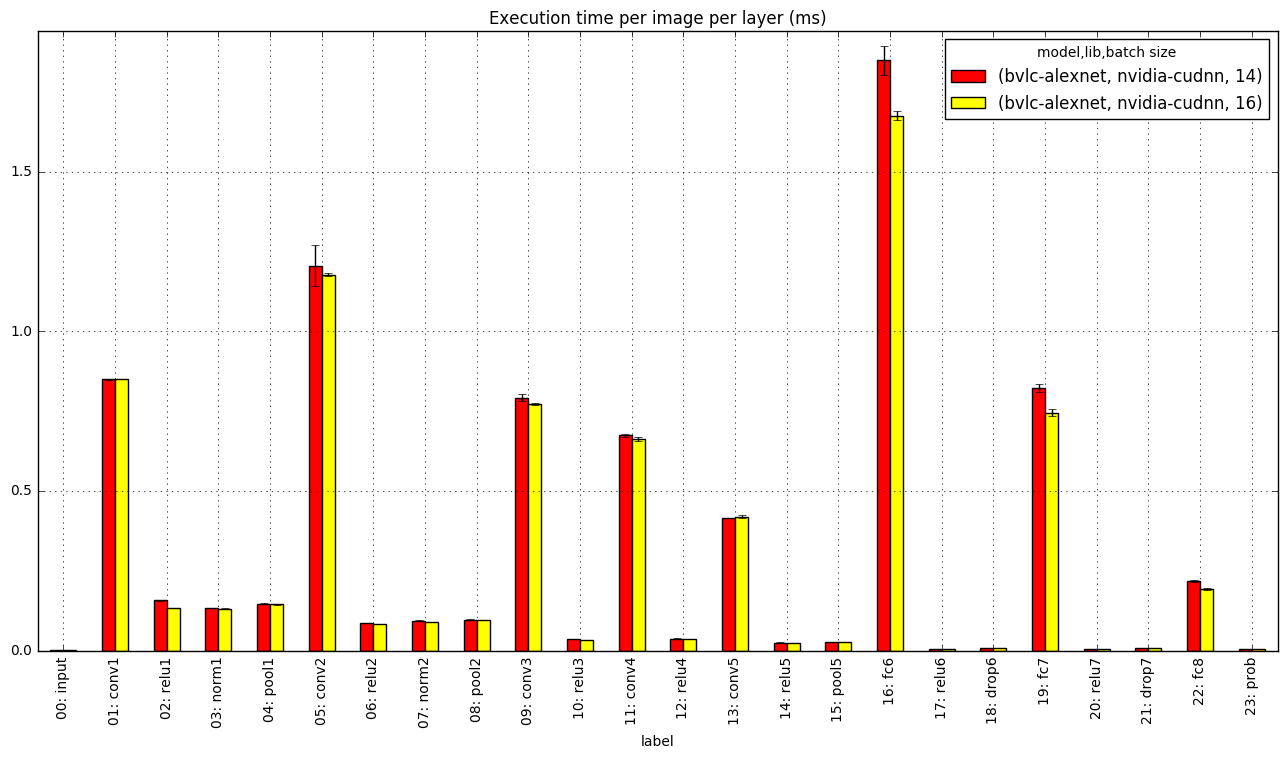

In [61]:
# Plot for a list of batch sizes.
# NB: This suggests that the batch size of 16 is better than 14 for the fully connected layers fc6, fc7, fc8.
plot_time_per_image_per_layer(df_per_layer_info, model='bvlc-alexnet', libs='nvidia-cudnn',
                              batch_sizes=[14, 16], direction=direction)

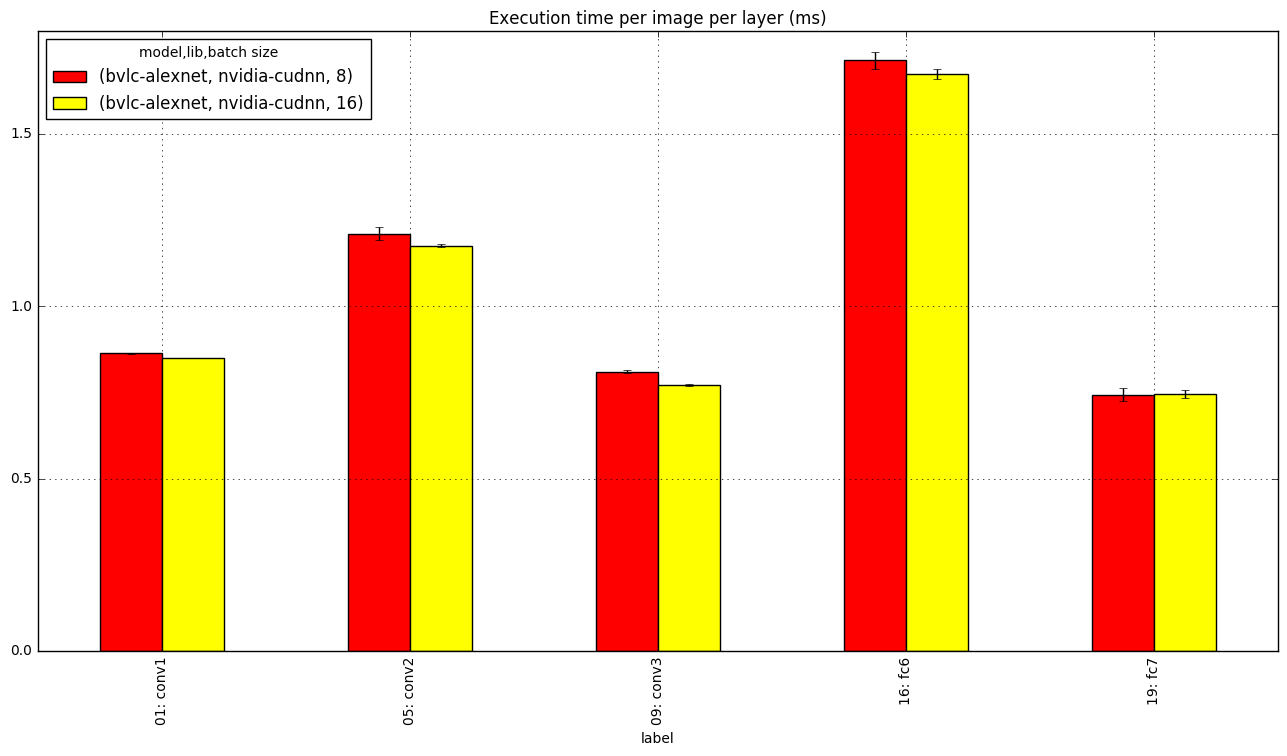

In [62]:
# Plot for a list of batch sizes. Only plot layers that consume at least 10% of the total execution time.
plot_time_per_image_per_layer(df_per_layer_info, model='bvlc-alexnet', libs='nvidia-cudnn',
                              batch_sizes=[8, 16], direction=direction, lower=0.10)

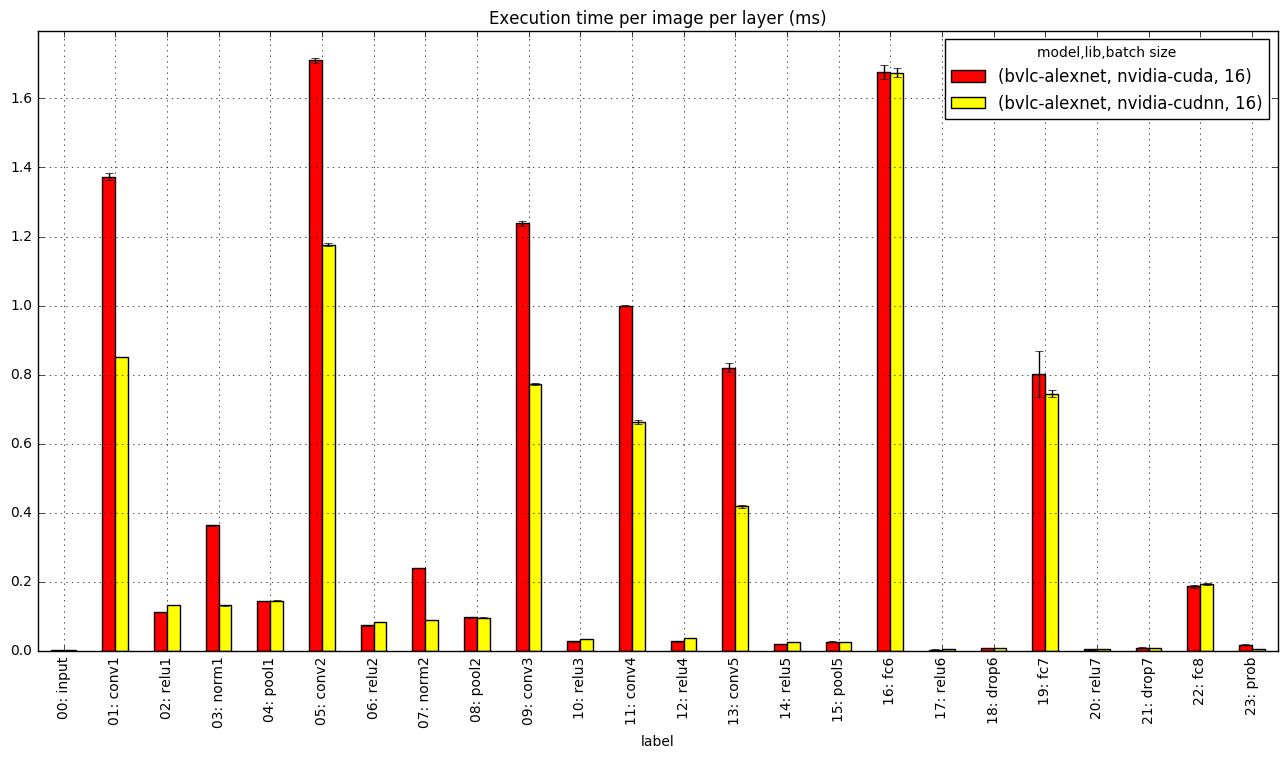

In [63]:
# Plot for a list of libs.
# NB: cuDNN and cuBLAS perform about the same on the fully connected layers (which suggests that
# cuDNN falls back to cuBLAS for these).
# Unsurprisingly, cuDNN performs better than cuBLAS on the convolution layers.
# Surprisingly, cuBLAS performs a bit better than cuDNN on the relu layers.
plot_time_per_image_per_layer(df_per_layer_info, model='bvlc-alexnet', libs=['nvidia-cuda','nvidia-cudnn'],
                              batch_sizes=16, direction=direction)

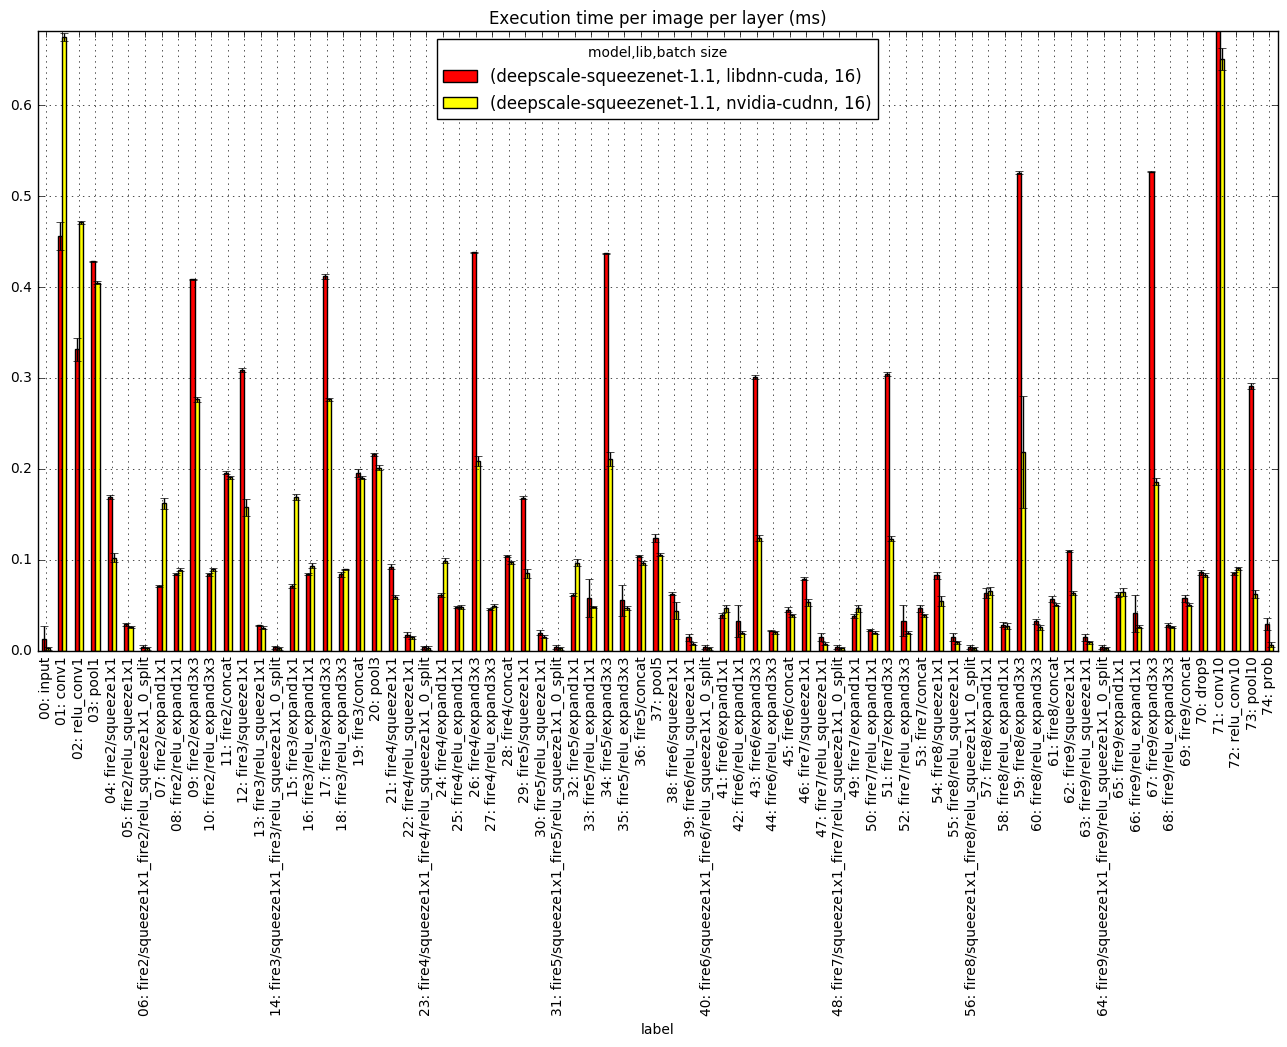

In [64]:
# Plot for a list of libs.
# NB: This suggests that libDNN is faster than cuDNN on the conv1 and expand1x1 layers, but slower on the squeeze1x1, 
# expand3x3, conv/pool10 layers. (Recall that libDNN is not yet tuned for TX1 but uses parameters optimal for GTX 1080.)
plot_time_per_image_per_layer(df_per_layer_info, model='deepscale-squeezenet-1.1', libs=['nvidia-cudnn', 'libdnn-cuda'],
                              batch_sizes=16, direction=direction, ymax=0.65)

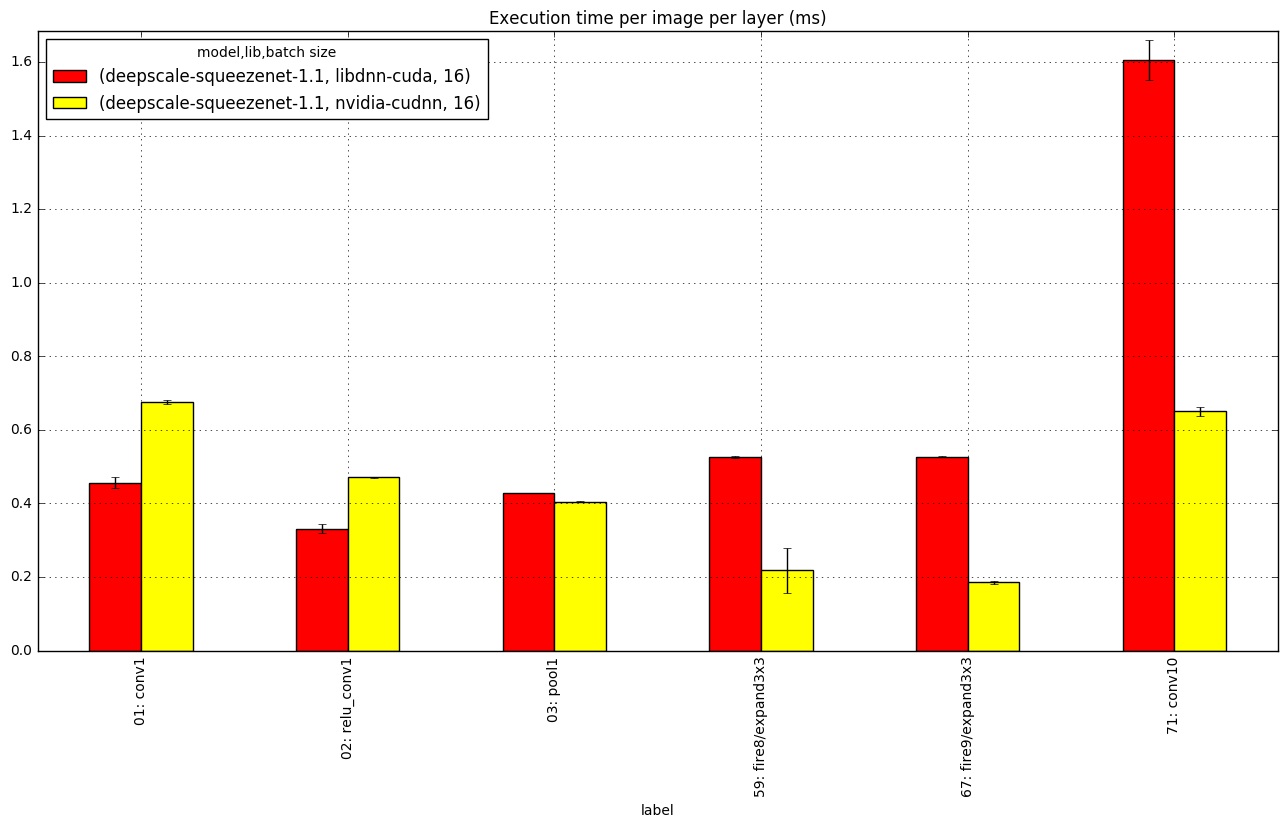

In [65]:
# Plot for a list of libs. Only plot layers that consume between 5% and 20% of the total execution time.
# NB: libDNN is slower than cuDNN on the expand3x3 layers and conv10 layers, but a bit faster on the conv1 layer.
plot_time_per_image_per_layer(df_per_layer_info, model='deepscale-squeezenet-1.1', libs=['nvidia-cudnn', 'libdnn-cuda'],
                              batch_sizes=16, direction=direction, lower=0.05, upper=0.20)

<a id="plot_ideal"></a>
## Plot the ideal adaptive solution

Overall, using cuDNN typically results in the minimum execution time. For some layers, however, other libraries may outperform cuDNN (e.g. libDNN from the OpenCL branch of Caffe). As we show below, using the best performing library per layer results in up to 17% execution time reduction over using cuDNN alone. For other models and on other platforms such adaptation can potentially results even in higher savings (e.g. up to 22% on the GTX 1080).

**NB:** Currently, the savings are hypothetical. However, Caffe allows for manual adaptation, i.e. the user can specify the engine to use for each layer in the model file (`*.prototxt`). We are working on generating the optimized model file automatically from the obtained ideal adaptive solution.

<a id="plot_ideal_all"></a>
### Using all reasonable libs for adaptation

We only include libs built from the master and OpenCL branches because per layer adaptation implies building from the same source. The OpenCL branch is kept in sync with the master, while the NVIDIA branches are not.

In [66]:
all_libs = df_per_layer_info.index.get_level_values('lib').drop_duplicates() \
    .drop(['nvidia-fp16-cuda','nvidia-fp16-cudnn'])
all_libs

Index([u'cpu', u'libdnn-cuda', u'nvidia-cuda', u'nvidia-cudnn'], dtype='object', name=u'lib')

Each row specifies an ideal adaptive solution for a model. Each column specifies the execution time (in ms per image) that the ideal adaptive solution would cumulatively spend using a particular library.

In [67]:
df_ideal_all = get_ideal_adaptive_solution(df_per_layer_info, all_libs, direction)
df_ideal_all

lib,cpu,libdnn-cuda,nvidia-cuda,nvidia-cudnn
model,,,,
deepscale-squeezenet-1.1,0.002339,0.825522,2.406508,3.063189
bvlc-alexnet,0.000500,1.656031,0.616434,4.804996
deepscale-squeezenet-1.0,0.002098,0.861213,3.959106,6.824531
bvlc-googlenet,0.003723,0.166052,4.076741,11.693360


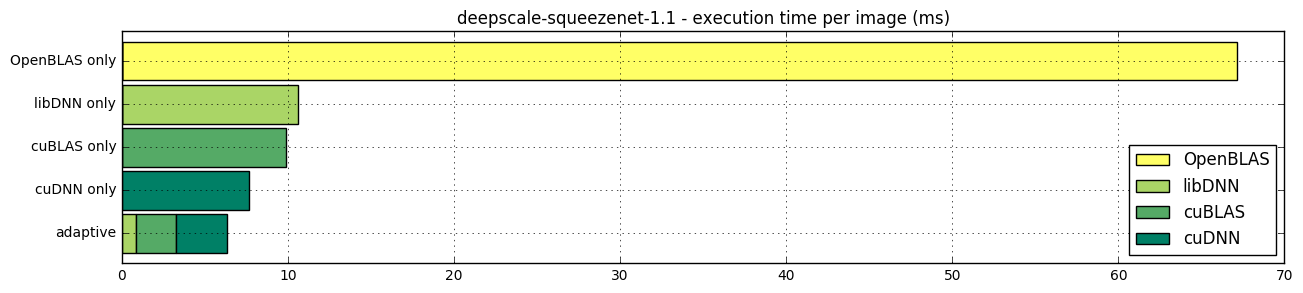

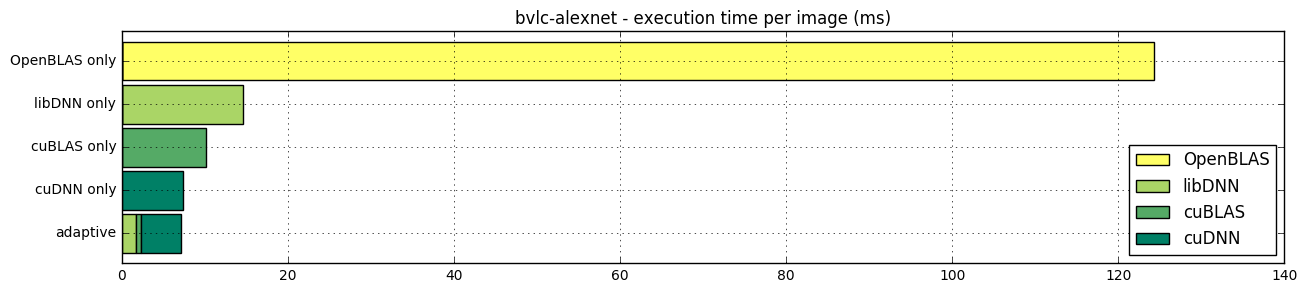

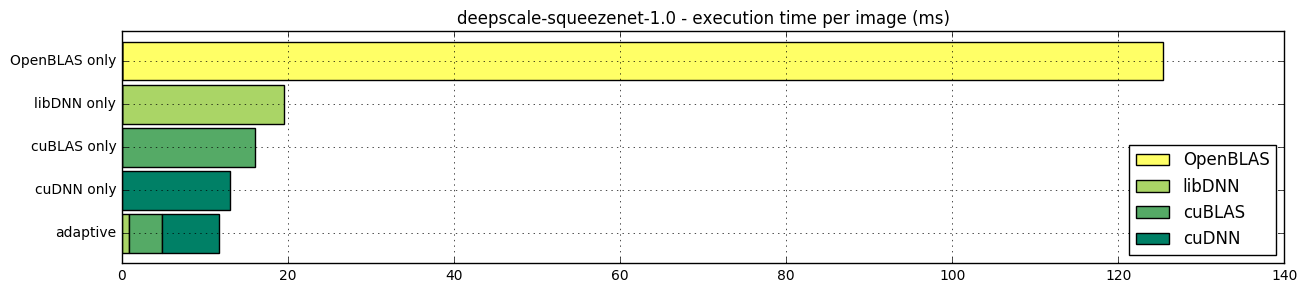

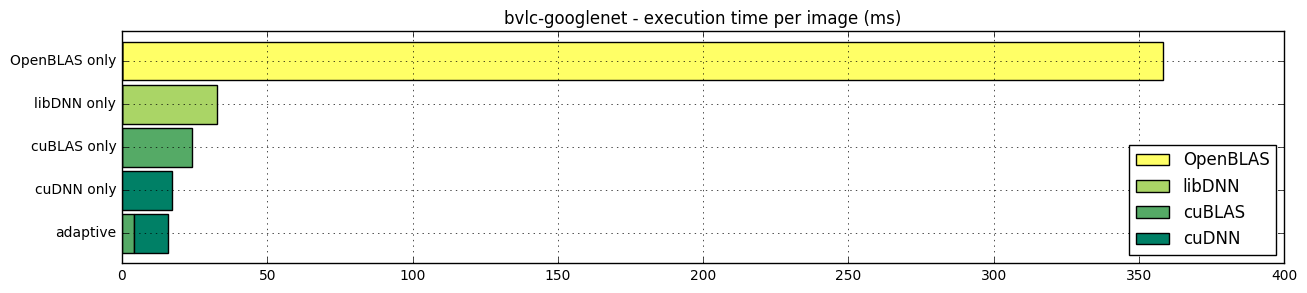

In [68]:
plot_ideal_adaptive_solution(df_ideal_all, df_model_lib_mean)

In [69]:
# Up to 17% execution time reduction compared to the best non-adaptive solution (i.e. cuDNN).
df_best_lib = df_model_lib_mean.reorder_levels(['lib', 'model'])[cuda_level_performance].unstack('lib')
df_ideal_all.sum(axis=1) / df_best_lib.min(axis=1)

model
bvlc-alexnet                0.954758
bvlc-googlenet              0.931626
deepscale-squeezenet-1.0    0.895721
deepscale-squeezenet-1.1    0.821986
dtype: float64

<a id="plot_ideal_cuda"></a>
### Using CUDA-level performance libs for adaptation

In [70]:
df_ideal_cuda = get_ideal_adaptive_solution(df_per_layer_info, cuda_level_performance, direction)
df_ideal_cuda

lib,nvidia-cuda,nvidia-cudnn,libdnn-cuda
model,,,
deepscale-squeezenet-1.1,2.414011,3.066857,0.825522
bvlc-alexnet,0.616434,4.806335,1.656031
deepscale-squeezenet-1.0,3.962985,6.830830,0.861213
bvlc-googlenet,4.077942,11.704643,0.166052


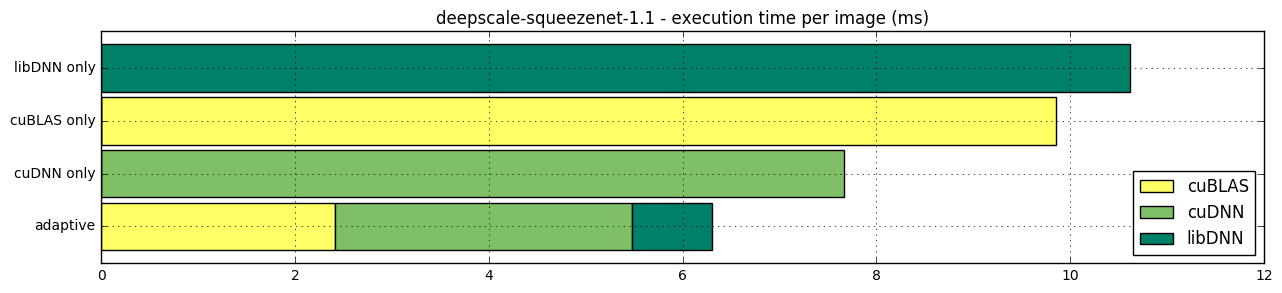

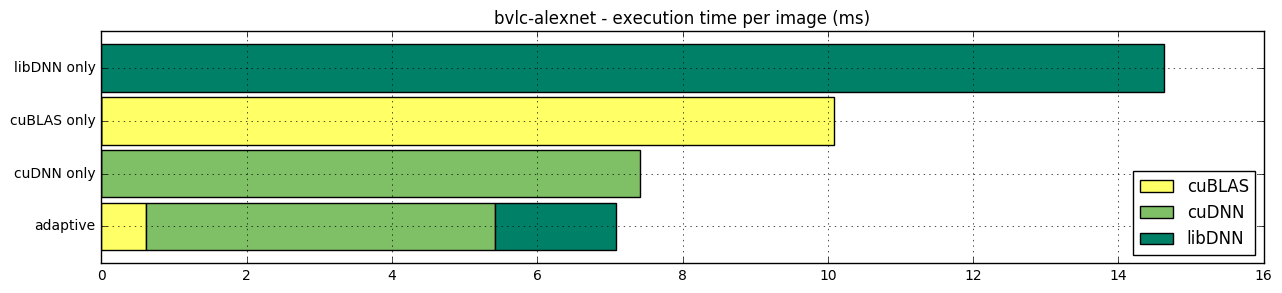

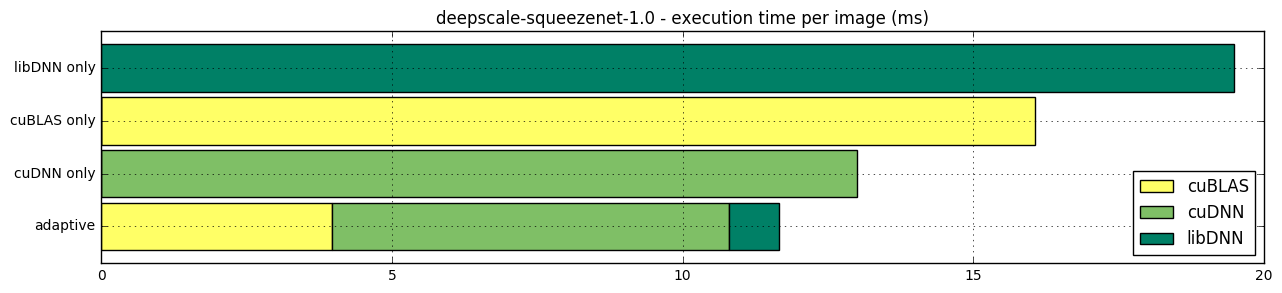

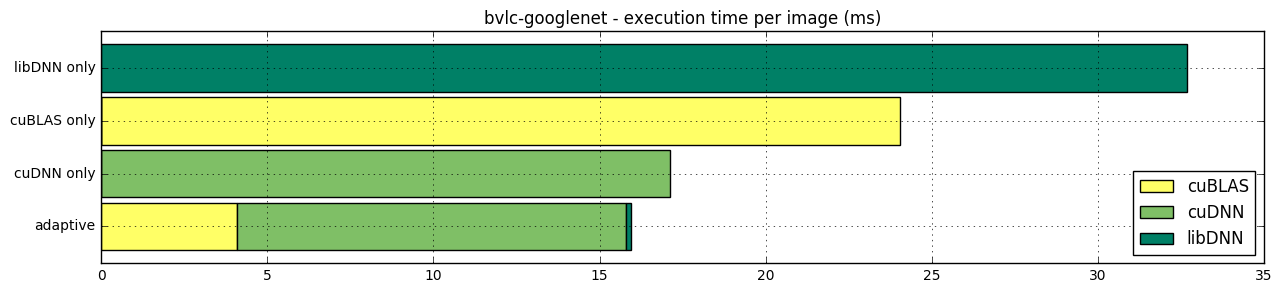

In [71]:
plot_ideal_adaptive_solution(df_ideal_cuda, df_model_lib_mean)

In [72]:
# Hypothetical execution time reduction compared to the best non-adaptive solution (i.e. cuDNN).
df_best_lib = df_model_lib_mean.reorder_levels(['lib', 'model'])[cuda_level_performance].unstack('lib')
df_ideal_cuda.sum(axis=1) / df_best_lib.min(axis=1)

model
bvlc-alexnet                0.954871
bvlc-googlenet              0.932139
deepscale-squeezenet-1.0    0.896342
deepscale-squeezenet-1.1    0.823139
dtype: float64

In [73]:
# Up to 0.1% worse performance when using the CUDA-level performance libs only.
df_ideal_cuda.sum(axis=1) / df_ideal_all.sum(axis=1)

model
deepscale-squeezenet-1.1    1.001402
bvlc-alexnet                1.000119
deepscale-squeezenet-1.0    1.000694
bvlc-googlenet              1.000550
dtype: float64

<a id="plot_ideal_cudnn_cublas"></a>
### Using cuDNN and cuBLAS for adaptation

In [74]:
df_ideal_cudnn_cublas = get_ideal_adaptive_solution(df_per_layer_info, ['nvidia-cudnn', 'nvidia-cuda'], direction)
df_ideal_cudnn_cublas

lib,nvidia-cudnn,nvidia-cuda
model,,
deepscale-squeezenet-1.1,4.323794,2.474317
bvlc-alexnet,6.469998,0.616434
deepscale-squeezenet-1.0,8.072759,3.962985
bvlc-googlenet,11.917162,4.077942


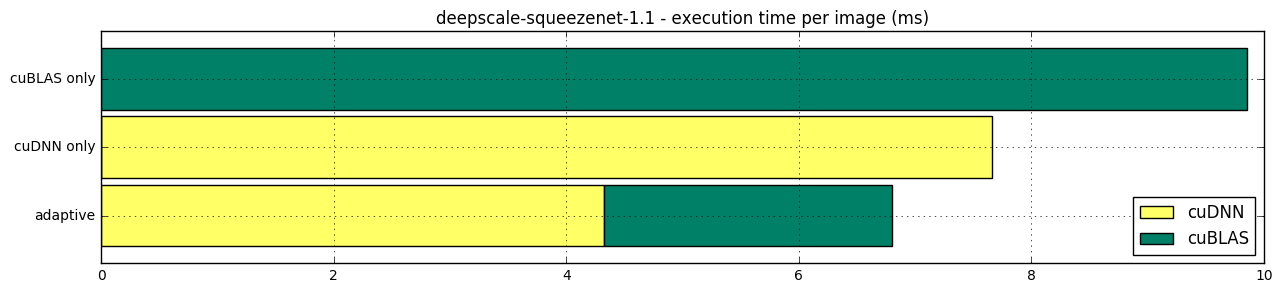

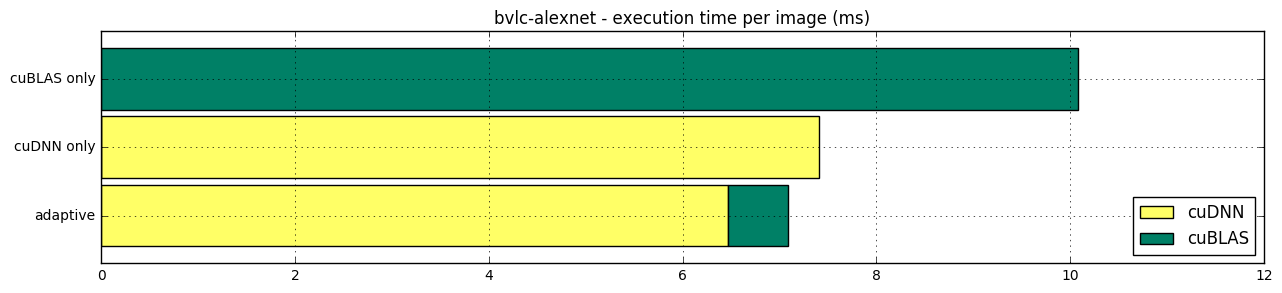

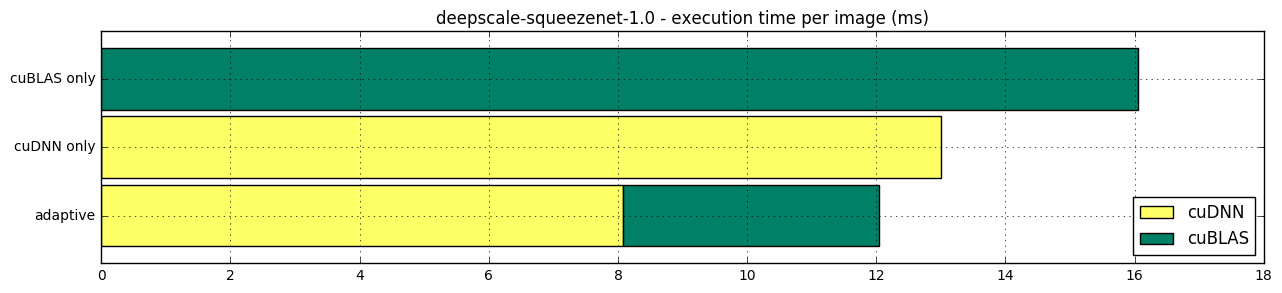

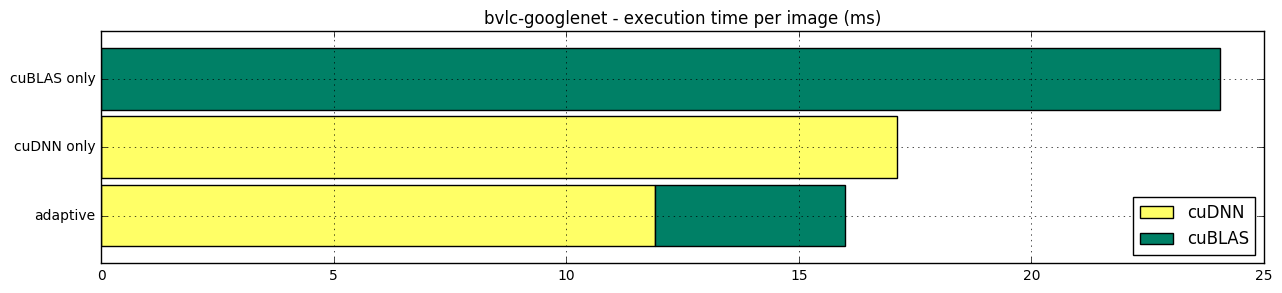

In [75]:
plot_ideal_adaptive_solution(df_ideal_cudnn_cublas, df_model_lib_mean)

In [76]:
# Hypothetical execution time reduction compared to the best non-adaptive solution (i.e. cuDNN).
df_best_lib = df_model_lib_mean.reorder_levels(['lib', 'model'])[cuda_level_performance].unstack('lib')
df_ideal_cudnn_cublas.sum(axis=1) / df_best_lib.min(axis=1)

model
bvlc-alexnet                0.955901
bvlc-googlenet              0.934854
deepscale-squeezenet-1.0    0.925622
deepscale-squeezenet-1.1    0.887320
dtype: float64

In [77]:
# Up to 8% worse performance when using cuDNN+cuBLAS only.
df_ideal_cudnn_cublas.sum(axis=1) / df_ideal_all.sum(axis=1)

model
deepscale-squeezenet-1.1    1.079484
bvlc-alexnet                1.001197
deepscale-squeezenet-1.0    1.033382
bvlc-googlenet              1.003465
dtype: float64

<a id="plot_ideal_cudnn_libdnn"></a>
### Using cuDNN and libDNN for adaptation

In [78]:
df_ideal_cudnn_libdnn = get_ideal_adaptive_solution(df_per_layer_info, ['nvidia-cudnn', 'libdnn-cuda'], direction)
df_ideal_cudnn_libdnn

lib,nvidia-cudnn,libdnn-cuda
model,,
deepscale-squeezenet-1.1,4.672342,1.735223
bvlc-alexnet,5.180496,1.925741
deepscale-squeezenet-1.0,9.148563,2.605430
bvlc-googlenet,14.880228,1.208790


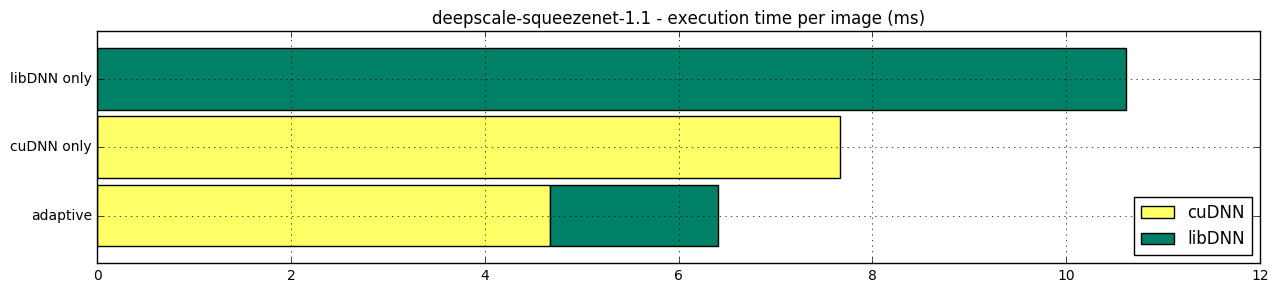

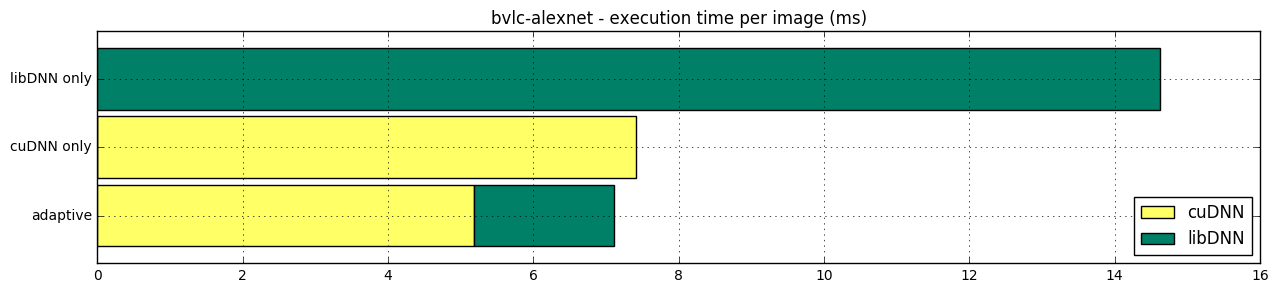

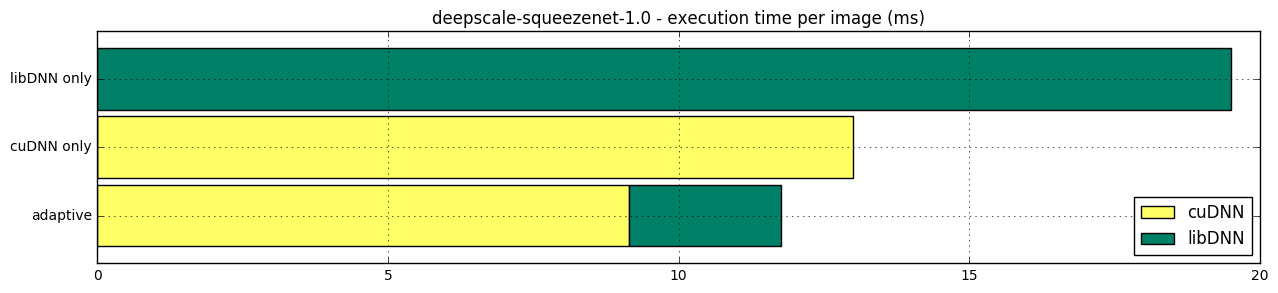

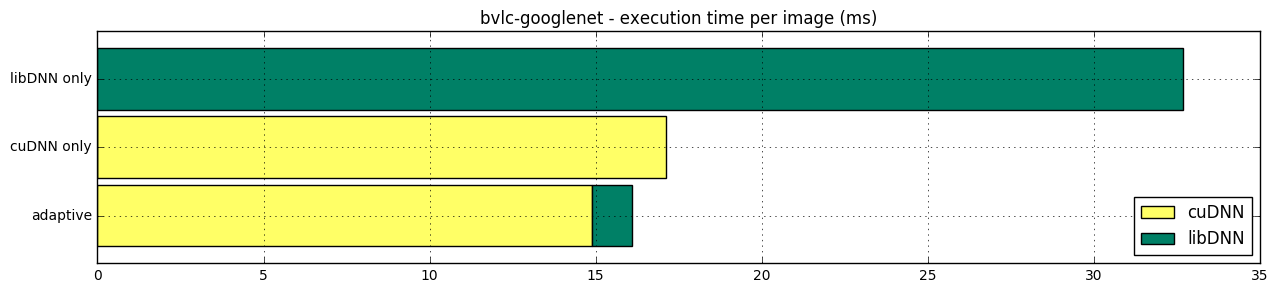

In [79]:
plot_ideal_adaptive_solution(df_ideal_cudnn_libdnn, df_model_lib_mean)

In [80]:
# Hypothetical execution time reduction compared to the best non-adaptive solution (i.e. cuDNN).
df_best_lib = df_model_lib_mean.reorder_levels(['lib', 'model'])[cuda_level_performance].unstack('lib')
df_ideal_cudnn_libdnn.sum(axis=1) / df_best_lib.min(axis=1)

model
bvlc-alexnet                0.958573
bvlc-googlenet              0.940343
deepscale-squeezenet-1.0    0.903953
deepscale-squeezenet-1.1    0.836344
dtype: float64

In [81]:
# Less than 2% worse performance when using cuDNN+libDNN only.
df_ideal_cudnn_libdnn.sum(axis=1) / df_ideal_all.sum(axis=1)

model
deepscale-squeezenet-1.1    1.017468
bvlc-alexnet                1.003995
deepscale-squeezenet-1.0    1.009191
bvlc-googlenet              1.009356
dtype: float64

<a id="plot_memory"></a>
## Plot memory consumption

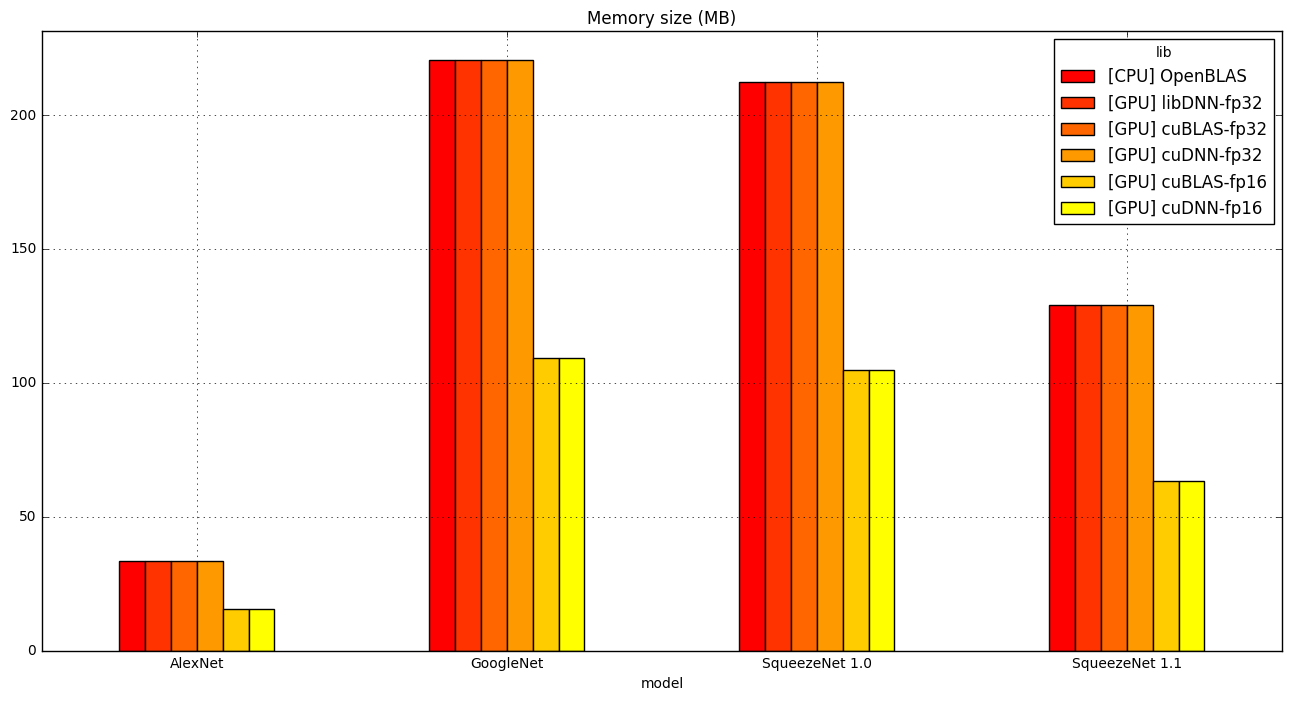

In [82]:
df_memory = df_all['memory (MB)']
# Batch size of 4; repetition 0 (should always be available).
df_memory = df_memory.unstack(['model','lib']).loc[4].loc[0].unstack('lib')
plot(mean=df_memory.rename(columns=pretty_print_libs, index=pretty_print_models), std=pd.DataFrame(), title='Memory size (MB)')

<a id="balance_memory_time"></a>
### Balance memory consumption and execution time per image

The above, however, does not tell the full story. The memory consumption, as reported by Caffe, increases linearly with the batch size. In other words, the memory consumption per image is constant. (Note that extra memory may be required e.g. for GPU buffers in host memory.)

The execution time per image, however, decreases asymptotically. Since minimizing the execution time almost always should be balanced with minimizing the memory consumption, we should select the batch size that results in "good enough" performance.

We give several examples below. Note that the execution time per batch is omitted to make the execution time per image more pronounced.

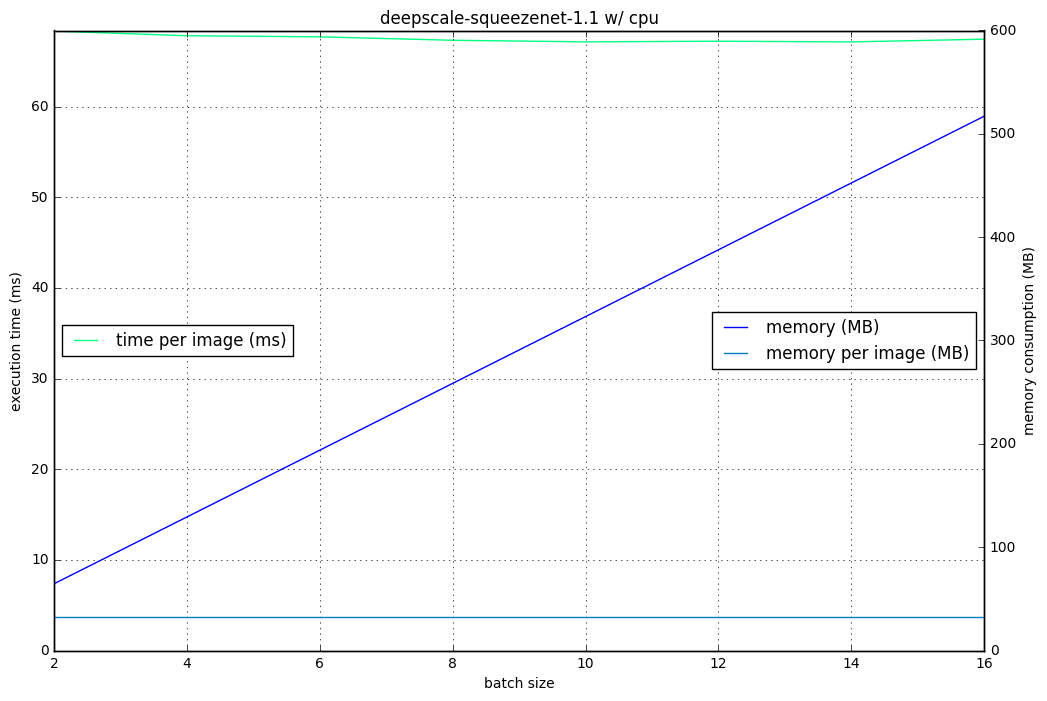

In [83]:
# Is the batch size of 2 "good enough"?
plot_time_per_image_and_memory_consumption(df_all, 'deepscale-squeezenet-1.1', 'cpu')

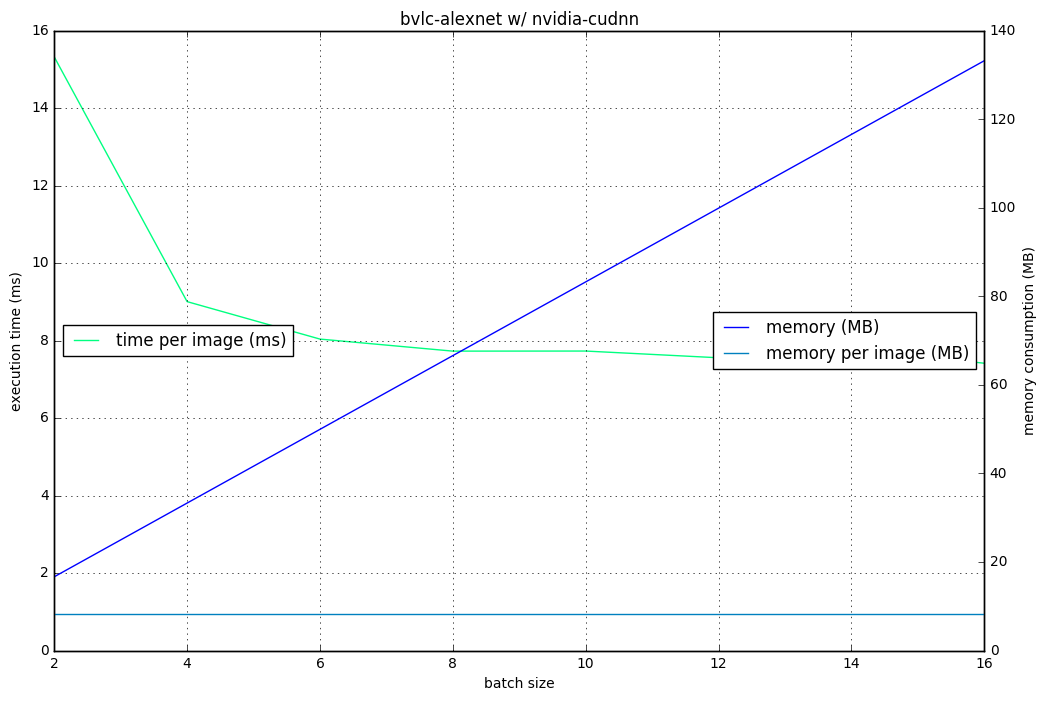

In [84]:
# Is the batch size of 8 "good enough"?
plot_time_per_image_and_memory_consumption(df_all, 'bvlc-alexnet', 'nvidia-cudnn')

<a id="alexnet_vs_squeezenet"></a>
## Compare AlexNet and SqueezeNet 1.1

<a id="alexnet_vs_squeezenet_memory"></a>
### Memory consumption

In [85]:
# SqueezeNet consumes about 4 times more memory than AlexNet.
df_memory.ix[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].iloc[1] / \
df_memory.ix[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].iloc[0]

lib
cpu                  3.882476
libdnn-cuda          3.882476
nvidia-cuda          3.882476
nvidia-cudnn         3.882476
nvidia-fp16-cuda     4.113806
nvidia-fp16-cudnn    4.113806
dtype: float64

<a id="alexnet_vs_squeezenet_time"></a>
### Execution time

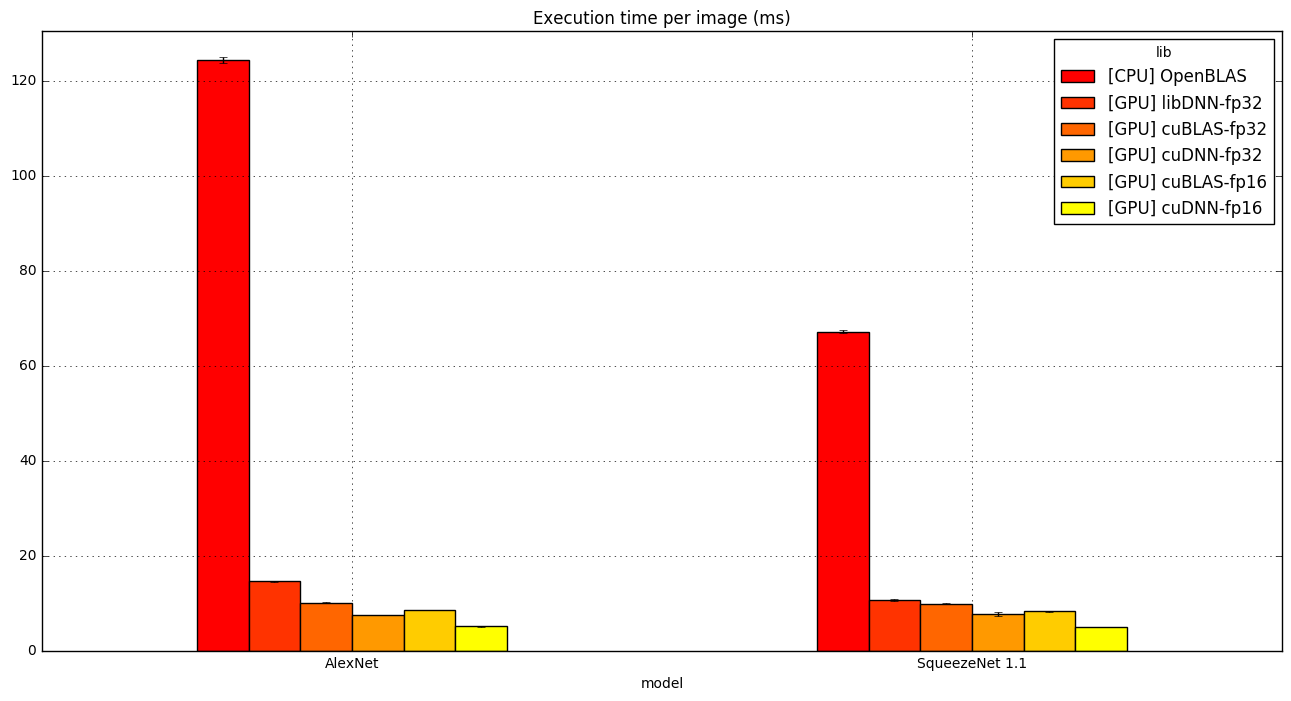

In [86]:
mean = df_model_lib_mean[['bvlc-alexnet', 'deepscale-squeezenet-1.1']] \
            .unstack('lib').rename(columns=pretty_print_libs, index=pretty_print_models)
std  = df_model_lib_std[['bvlc-alexnet', 'deepscale-squeezenet-1.1']] \
            .unstack('lib').rename(columns=pretty_print_libs, index=pretty_print_models)
plot(mean, std)

In [87]:
# Using OpenBLAS, SqueezeNet is almost 2x faster than AlexNet.
# Using libDNN, SqueezeNet 1.1 is up 28% faster than AlexNet.
df_model_lib_mean[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].unstack('lib').iloc[1] / \
df_model_lib_mean[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].unstack('lib').iloc[0]

lib
cpu                  0.540034
libdnn-cuda          0.726139
nvidia-cuda          0.977500
nvidia-cudnn         1.033459
nvidia-fp16-cuda     0.961526
nvidia-fp16-cudnn    0.989633
dtype: float64

<a id="conclusion"></a>
## Conclusion

<a id="improvements_of_each_approach"></a>
### What are the improvements brought on by each approach?

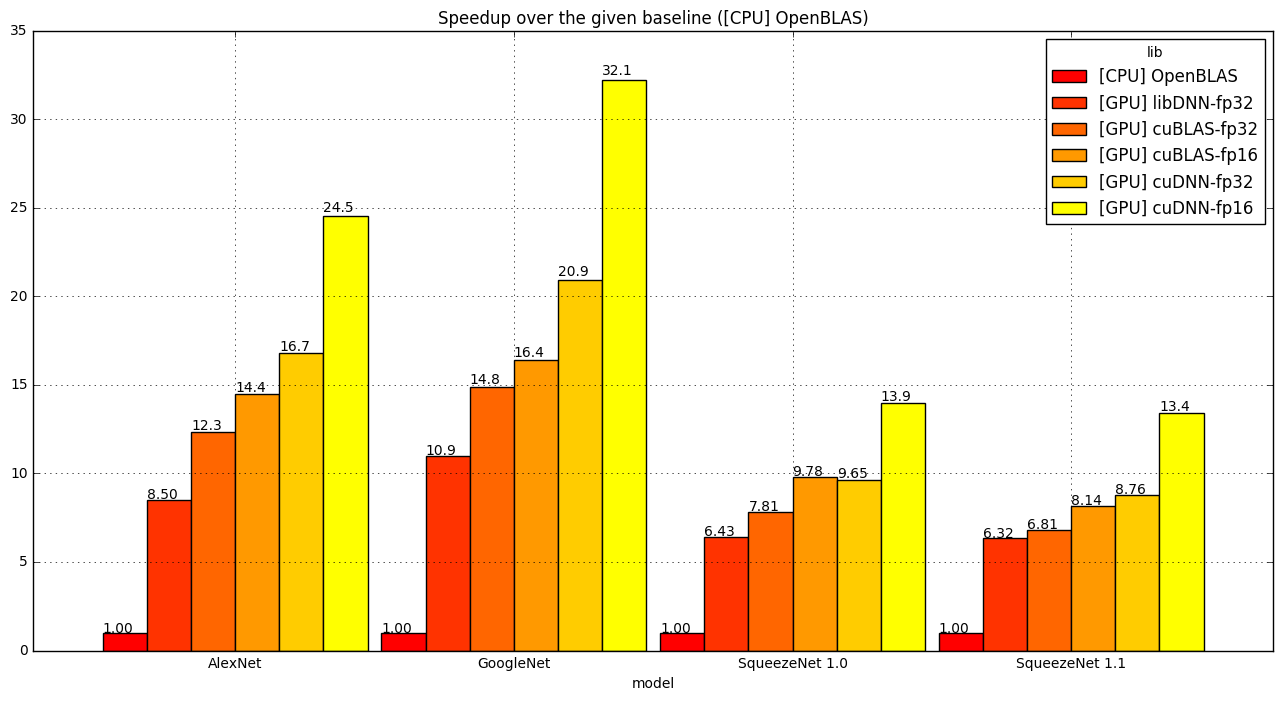

In [88]:
# The GPU is up to 32x faster than the CPU.
plot_speedup_over_baseline(df_mean_time_per_image, libs_to_drop=[])

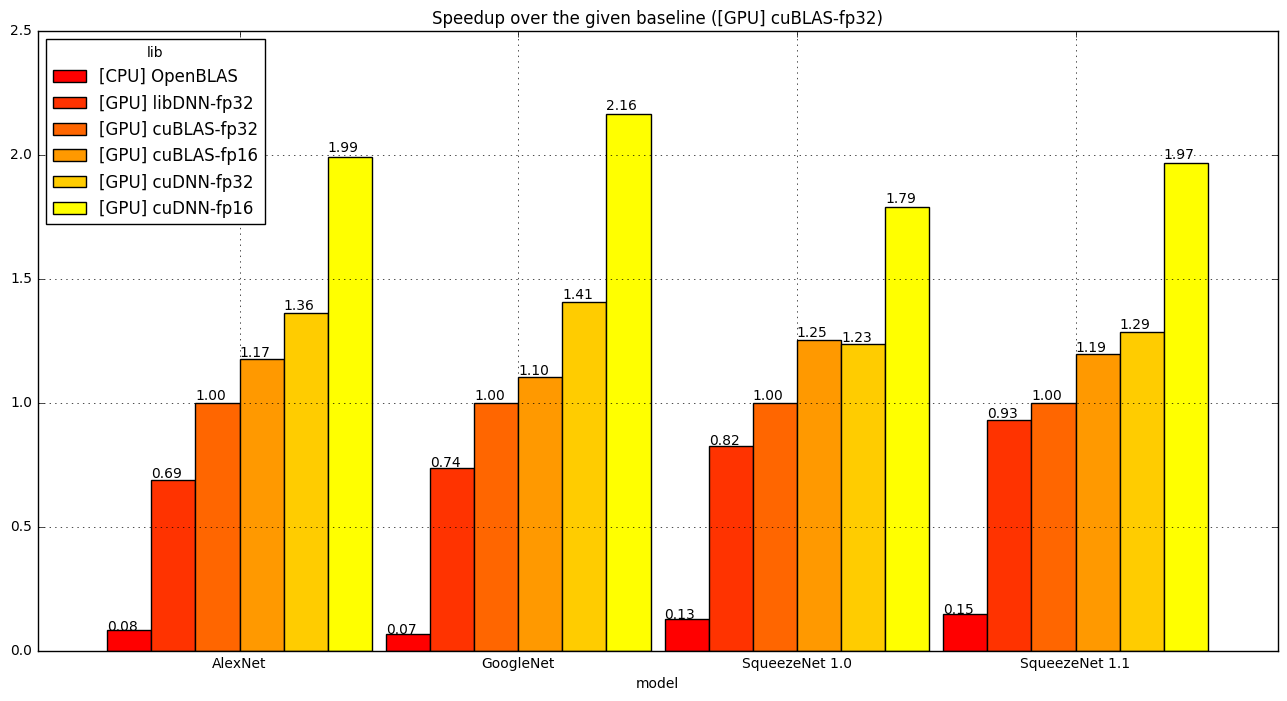

In [89]:
# cuBLAS-fp16 is up to 25% faster than cuBLAS-fp32.
# cuDNN-fp32 is up to 41% faster than cuBLAS-fp32.
# cuDNN-fp16 is about 2x faster than cuBLAS-fp32.
plot_speedup_over_baseline(df_mean_time_per_image, libs_to_drop=[], baseline='nvidia-cuda')

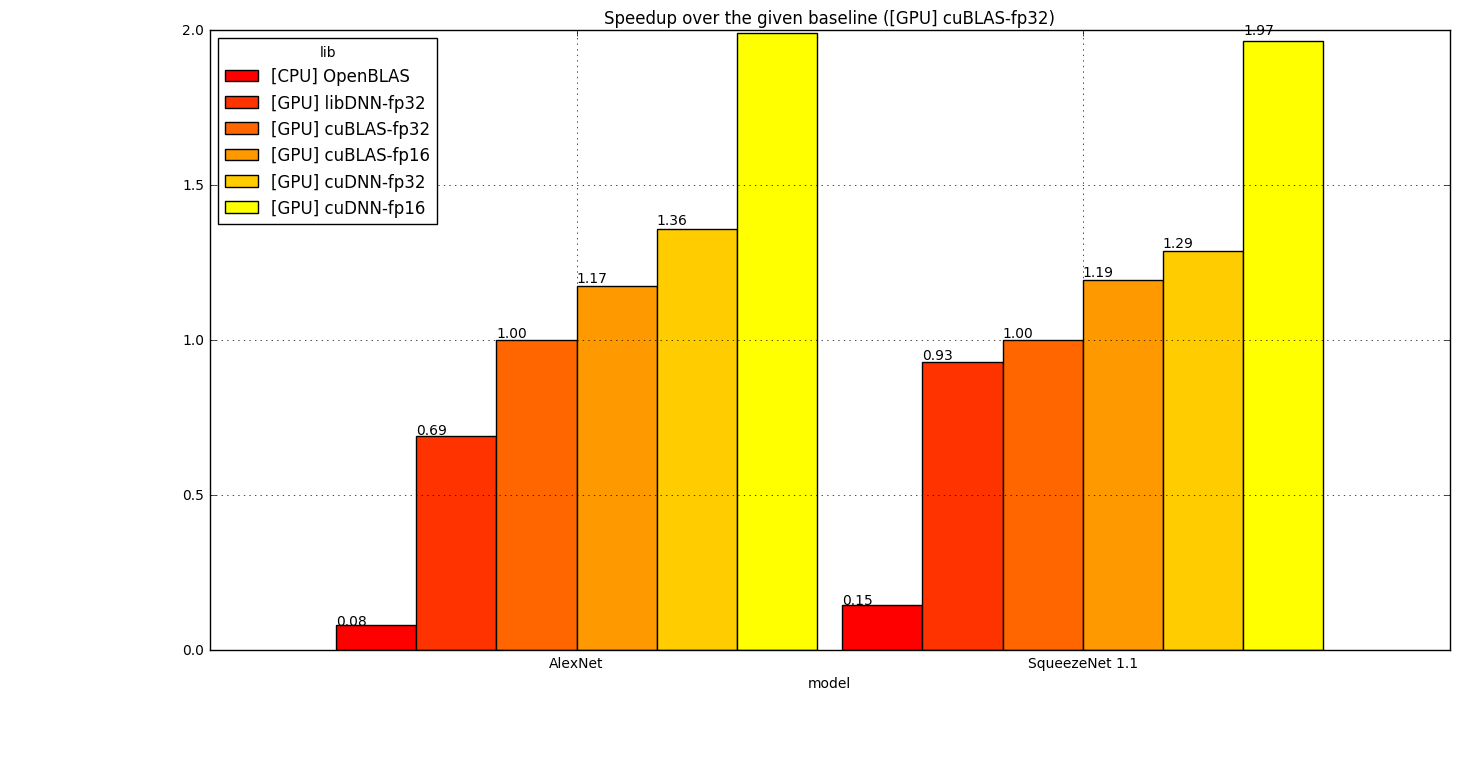

In [90]:
# AlexNet and SqueezeNet 1.1 have very similar performance with cuBLAS and cuDNN. (They also have very similar accuracy!)
# At the same time, SqueezeNet requires about 4 times more memory than AlexNet (at least, with Caffe), so it's a trade-off.
plot_speedup_over_baseline(df_mean_time_per_image.ix[['bvlc-alexnet', 'deepscale-squeezenet-1.1']], libs_to_drop=[],
                           baseline='nvidia-cuda')

<a id="tx1_vs_myriad2"></a>
### How does TX1 compare to Myriad 2?

In [91]:
Image(url="https://1.bp.blogspot.com/-aQw-r1FZcQk/VyINpA8ntxI/AAAAAAAAPF4/o34l1MvKJVQTuLD1qsv5Ink-04Dra0PDgCLcB/s1600/Movidius%2BFathom-1.JPG")

[According to Movidius](http://uploads.movidius.com/1461814467-Fathom-Combined-2-pager.pdf), using fp16 their Myriad 2 processor runs GoogleNet at 15 images per second (~67 ms per image), while consumes under 1 Watt of power (~15 images per second per Watt).

[According to the NVIDIA 2015 whitepaper](https://www.nvidia.com/content/tegra/embedded-systems/pdf/jetson_tx1_whitepaper.pdf), using fp16 their TX1 processor runs GoogleNet at up to 75 images per second, while consumes up to 6 Watts of power (~13 images per second per Watt).

 This would make TX1 and Myriad 2 **roughly equivalent** in terms of images per second per unit power.

[According to the NVIDIA blog introducing TensorRT](https://devblogs.nvidia.com/parallelforall/jetpack-doubles-jetson-tx1-deep-learning-inference/blog), the performance improvements brought by TensorRT might swing the comparison in favour of NVIDIA even for small batch sizes: ~18-22 images per second per Watt.

In [92]:
Image(url="https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/09/Figure_2-1.png")

In [93]:
Image(url="https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/09/Figure_3-1.png")

<a id="ck_on_dl"></a>
# Collective Knowledge on Deep Learning

In [97]:
Image(url="http://www.engagementaustralia.org.au/blog/wp-content/uploads/2015/03/6-blind-men-hans.jpg")

## http://cknowledge.org/ai - crowdsourcing benchmarking and optimisation of AI

### System benchmarking and optimisation (this talk)

* [Android app](https://play.google.com/store/apps/details?id=openscience.crowdsource.video.experiments&hl=en_GB)
* [Desktop app](https://github.com/dividiti/ck-crowdsource-dnn-optimization)
* [CK-Caffe](https://github.com/dividiti/ck-caffe)
* [CK-TensorFlow](https://github.com/ctuning/ck-tensorflow)
* [CK-TensorRT](https://github.com/dividiti/ck-tensorrt)
* etc.

### Model design (future work)

In [98]:
Image(url="https://cdn-images-1.medium.com/max/1000/1*C4Y78hoaN0hPxyWJnkG5vQ.png")

In [99]:
Image(url="https://qiita-image-store.s3.amazonaws.com/0/100523/85381a68-1842-6d2e-e7f2-ced494c6a978.png")

### Is it possible to achieve even higher accuracy and better performance?

(**Your** research here.)

# Enabling efficient, reliable and cheap computing - everywhere!

In [100]:
Image(url="http://memecrunch.com/meme/4Z8BF/on-a-mission-from-god/image.jpg")